In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from bs4 import BeautifulSoup
import requests
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



In [161]:
df_2020 = pd.read_csv("transactions_2020.csv")

In [162]:
df_2020.head()

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,...,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
0,12/31/20,14:02:13,Eastern Time (US & Canada),$55.00,$0.00,$55.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZG9G7K92E4535SAB6D5T51WCM0D,01/03/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
1,12/28/20,08:56:42,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZTVSBZATGYX4A10NTWDSBZZSK1S,12/28/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
2,12/27/20,10:17:39,Eastern Time (US & Canada),$130.00,$0.00,$130.00,$0.00,$0.00,$0.00,$0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete,NaN
3,12/26/20,17:06:22,Eastern Time (US & Canada),$60.00,$0.00,$60.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZQD37PXGRE11AHFB5ANKBWR5F2D,12/26/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
4,12/23/20,13:54:09,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZRK59MEZJQ1291F1VYG5XVN2EAS,12/23/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN


In [163]:
df_2020.dtypes

Date                      object
Time                      object
Time Zone                 object
Gross Sales               object
Discounts                 object
Net Sales                 object
Gift Card Sales           object
Tax                       object
Tip                       object
Partial Refunds           object
Total Collected           object
Source                    object
Card                      object
Card Entry Methods        object
Cash                      object
Square Gift Card          object
Other Tender              object
Other Tender Type         object
Other Tender Note         object
Fees                      object
Net Total                 object
Transaction ID            object
Payment ID                object
Card Brand                object
PAN Suffix                object
Device Name               object
Staff Name                object
Staff ID                 float64
Details                   object
Description               object
Event Type

In [164]:
df_2020.isnull().sum()

Date                       0
Time                       0
Time Zone                  0
Gross Sales                0
Discounts                  0
Net Sales                  0
Gift Card Sales            0
Tax                        0
Tip                        0
Partial Refunds            0
Total Collected            0
Source                     0
Card                       0
Card Entry Methods        29
Cash                       0
Square Gift Card           0
Other Tender               0
Other Tender Type        170
Other Tender Note        171
Fees                       0
Net Total                  0
Transaction ID             0
Payment ID                 0
Card Brand                29
PAN Suffix                29
Device Name              120
Staff Name                52
Staff ID                 173
Details                    0
Description                1
Event Type                 0
Location                   0
Dining Option            173
Customer ID                6
Customer Name 

NaN in data frame are not affecting the analysis and/or predictions, so I'll drop the columns with NaN

In [165]:
df_2020.shape

(173, 46)

In [166]:
df_2020.dropna(axis=1, how='all')

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,...,Customer Name,Customer Reference ID,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status
0,12/31/20,14:02:13,Eastern Time (US & Canada),$55.00,$0.00,$55.00,$0.00,$0.00,$0.00,$0.00,...,Brittany Girton,NaN,3ZG9G7K92E4535SAB6D5T51WCM0D,01/03/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
1,12/28/20,08:56:42,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,Clydette Overturf,NaN,3ZTVSBZATGYX4A10NTWDSBZZSK1S,12/28/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
2,12/27/20,10:17:39,Eastern Time (US & Canada),$130.00,$0.00,$130.00,$0.00,$0.00,$0.00,$0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete
3,12/26/20,17:06:22,Eastern Time (US & Canada),$60.00,$0.00,$60.00,$0.00,$0.00,$0.00,$0.00,...,Carrie Moore,NaN,3ZQD37PXGRE11AHFB5ANKBWR5F2D,12/26/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
4,12/23/20,13:54:09,Eastern Time (US & Canada),$45.00,$0.00,$45.00,$0.00,$0.00,$0.00,$0.00,...,Shelby Lewis,NaN,3ZRK59MEZJQ1291F1VYG5XVN2EAS,12/23/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,07/18/20,11:10:23,Eastern Time (US & Canada),$30.00,$0.00,$30.00,$0.00,$0.00,$0.00,$0.00,...,Jacquelyn Rodriguez,NaN,3Z526J4YFC851FDFQ74S3EBVD1RH,07/18/20,https://squareup.com/dashboard/sales/deposits/...,2.6,$0.10,NaN,NaN,Complete
169,07/16/20,11:50:57,Eastern Time (US & Canada),$32.50,$0.00,$32.50,$0.00,$0.00,$0.00,$0.00,...,Bantu Mwaura,NaN,3Z621C42VVAX4S5CQXJGDNY62Y5N,07/16/20,https://squareup.com/dashboard/sales/deposits/...,2.6,$0.10,NaN,NaN,Complete
170,07/09/20,13:05:26,Eastern Time (US & Canada),$40.00,$0.00,$40.00,$0.00,$0.00,$0.00,$0.00,...,Alicia Giangrisostomi,NaN,3Z09QEN1FHJH06BD40D6WKESM199,07/10/20,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete
171,07/08/20,09:15:00,Eastern Time (US & Canada),$20.00,$0.00,$20.00,$0.00,$0.00,$0.00,$0.00,...,Tommy Moore,NaN,3Z09QEN1FHJH06BD40D6WKESM199,07/10/20,https://squareup.com/dashboard/sales/deposits/...,2.6,$0.10,NaN,NaN,Complete


In [167]:
df_2020['Date'] = pd.to_datetime(df_2020['Date'])

In [168]:
df_2020["Gross Sales"] = df_2020["Gross Sales"].replace({'\$':''}, regex = True)

In [169]:
df_2020.at[11, "Gross Sales"] = 1216.80

In [170]:
df_2020['Gross Sales'] = pd.to_numeric(df_2020["Gross Sales"])

In [171]:
df_2020["Gross Sales"].dtypes

dtype('float64')

In [172]:
df_2020["Net Sales"] = df_2020["Net Sales"].replace({'\$':''}, regex = True)

In [173]:
df_2020.at[11, "Net Sales"] = 1216.80

In [174]:
df_2020['Net Sales'] = pd.to_numeric(df_2020["Net Sales"])

In [175]:
df_2020["Net Sales"].dtypes

dtype('float64')

In [176]:
df_2020["Tip"] = df_2020["Tip"].replace({'\$':''}, regex = True)

In [177]:
df_2020['Tip'] = pd.to_numeric(df_2020["Tip"])

In [178]:
df_2020 = df_2020[["Date", "Time", "Gross Sales", "Net Sales", "Tip", "Source"]]

In [179]:
df_2020.head()

,Date,Time,Gross Sales,Net Sales,Tip,Source
0,2020-12-31,14:02:13,55.0,55.0,0.0,Invoices
1,2020-12-28,08:56:42,45.0,45.0,0.0,Invoices
2,2020-12-27,10:17:39,130.0,130.0,0.0,Point of Sale
3,2020-12-26,17:06:22,60.0,60.0,0.0,Invoices
4,2020-12-23,13:54:09,45.0,45.0,0.0,Invoices


In [180]:
df_2020['Time'] = pd.to_datetime(df_2020['Time'])

In [181]:
df_2020['Time'] = pd.to_datetime(df_2020['Time']).dt.time

In [182]:
df_2021 = pd.read_csv("transactions_2021.csv")

In [183]:
df_2021.head()

,Date,Time,Time Zone,Gross Sales,Discounts,Net Sales,Gift Card Sales,Tax,Tip,Partial Refunds,...,Device Nickname,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Refund Reason,Discount Name,Transaction Status,Order Reference ID
0,07/10/21,17:12:56,Eastern Time (US & Canada),$46.00,$0.00,$46.00,$0.00,$0.00,$3.00,$0.00,...,NaN,3Z4EAAT7HH810BB9D0QT5J0N1A4X,07/10/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
1,07/10/21,10:16:51,Eastern Time (US & Canada),$131.00,$0.00,$131.00,$0.00,$0.00,$0.00,$0.00,...,NaN,"3ZF9K9K6B4BS475E86YHJV6S5CRH, 3ZJFXBGA94B93EDB...","05/30/21, 07/10/21",https://squareup.com/dashboard/sales/deposits/...,"2.9, 2.9","$0.30, $0.30",NaN,NaN,Complete,NaN
2,07/09/21,16:47:12,Eastern Time (US & Canada),$47.00,$0.00,$47.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZSTS0ENJM2D4QD6HTJYCPSENG2H,07/09/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN
3,07/09/21,08:56:50,Eastern Time (US & Canada),$60.00,$0.00,$60.00,$0.00,$0.00,$0.00,$0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete,NaN
4,07/08/21,18:38:38,Eastern Time (US & Canada),$55.00,$0.00,$55.00,$0.00,$0.00,$0.00,$0.00,...,NaN,3ZFV8KHWKDN55NN8WBHGHEWSXRVN,07/08/21,https://squareup.com/dashboard/sales/deposits/...,2.9,$0.30,NaN,NaN,Complete,NaN


In [184]:
df_2021.dtypes

Date                      object
Time                      object
Time Zone                 object
Gross Sales               object
Discounts                 object
Net Sales                 object
Gift Card Sales           object
Tax                       object
Tip                       object
Partial Refunds           object
Total Collected           object
Source                    object
Card                      object
Card Entry Methods        object
Cash                      object
Square Gift Card          object
Other Tender              object
Other Tender Type         object
Other Tender Note         object
Fees                      object
Net Total                 object
Transaction ID            object
Payment ID                object
Card Brand                object
PAN Suffix                object
Device Name               object
Staff Name                object
Staff ID                 float64
Details                   object
Description               object
Event Type

In [185]:
df_2021.isnull().sum()

Date                       0
Time                       0
Time Zone                  0
Gross Sales                0
Discounts                  0
Net Sales                  0
Gift Card Sales            0
Tax                        0
Tip                        0
Partial Refunds            0
Total Collected            0
Source                     0
Card                       0
Card Entry Methods        37
Cash                       0
Square Gift Card           0
Other Tender               0
Other Tender Type        262
Other Tender Note        263
Fees                       0
Net Total                  0
Transaction ID             0
Payment ID                 0
Card Brand                37
PAN Suffix                37
Device Name              227
Staff Name                45
Staff ID                 267
Details                    0
Description                2
Event Type                 0
Location                   0
Dining Option            267
Customer ID               27
Customer Name 

In [186]:
df_2021.shape

(267, 46)

In [187]:
df_2021['Date'] = pd.to_datetime(df_2021['Date'])


In [188]:
df_2021['Time'] = pd.to_datetime(df_2021['Time'])

In [189]:
df_2021["Time"]

0     2021-07-22 17:12:56
1     2021-07-22 10:16:51
2     2021-07-22 16:47:12
3     2021-07-22 08:56:50
4     2021-07-22 18:38:38
              ...        
262   2021-07-22 09:06:12
263   2021-07-22 11:42:21
264   2021-07-22 12:58:16
265   2021-07-22 19:07:01
266   2021-07-22 09:46:23
Name: Time, Length: 267, dtype: datetime64[ns]

In [190]:
df_2021['Time'] = pd.to_datetime(df_2021['Time']).dt.time

In [191]:
df_2021["Gross Sales"] = df_2021["Gross Sales"].replace({'\$':''}, regex = True)


In [192]:
df_2021["Net Sales"] = df_2021["Net Sales"].replace({'\$':''}, regex = True)
df_2021["Tip"] = df_2021["Tip"].replace({'\$':''}, regex = True)

In [193]:
df_2021['Tip'] = pd.to_numeric(df_2021["Tip"])

In [194]:
df_2021 = df_2021[["Date", "Time", "Gross Sales", "Net Sales", "Tip", "Source"]]

In [195]:
df_2021.head()

,Date,Time,Gross Sales,Net Sales,Tip,Source
0,2021-07-10,17:12:56,46.00,46.00,3.0,Invoices
1,2021-07-10,10:16:51,131.00,131.00,0.0,Invoices
2,2021-07-09,16:47:12,47.00,47.00,0.0,Invoices
3,2021-07-09,08:56:50,60.00,60.00,0.0,Point of Sale
4,2021-07-08,18:38:38,55.00,55.00,0.0,Invoices


In [196]:
df_sales = df_2020.append(df_2021)

In [197]:
df_sales.head()

,Date,Time,Gross Sales,Net Sales,Tip,Source
0,2020-12-31,14:02:13,55,55,0.0,Invoices
1,2020-12-28,08:56:42,45,45,0.0,Invoices
2,2020-12-27,10:17:39,130,130,0.0,Point of Sale
3,2020-12-26,17:06:22,60,60,0.0,Invoices
4,2020-12-23,13:54:09,45,45,0.0,Invoices


In [198]:
df_sales.shape

(440, 6)

In [199]:
df_sales.to_csv("df_sales.csv")

In [200]:
df_traffic_2021 = pd.read_csv("traffic-over-time_2021.csv")

In [201]:
df_traffic_2021

,Day,Page Views,Site Sessions ⓘ,Unique Visitors,Site Bounce Rate ⓘ,Avg. Session Duration ⓘ
0,2021-07-11,192,19,15,26.00%,06m 53s
1,2021-04-17,144,33,28,36.00%,03m 06s
2,2021-03-30,144,27,26,37.00%,04m 05s
3,2021-04-19,137,37,36,49.00%,02m 35s
4,2021-05-13,132,32,29,41.00%,02m 50s
...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,00m 14s
195,2021-02-05,17,8,8,38.00%,01m 38s
196,2021-01-28,16,7,7,57.00%,00m 42s
197,2021-01-31,14,9,9,78.00%,00m 25s


In [202]:
df_traffic_2020 = pd.read_csv("traffic-over-time_2020.csv")

In [203]:
df_traffic = df_traffic_2020.append(df_traffic_2021)

In [204]:
df_traffic

,Day,Page Views,Site Sessions ⓘ,Unique Visitors,Site Bounce Rate ⓘ,Avg. Session Duration ⓘ
0,2020-12-10,104,14,11,21.00%,10m 01s
1,2020-06-30,93,17,17,59.00%,01m 32s
2,2020-08-06,87,15,10,33.00%,08m 04s
3,2020-06-25,86,10,5,60.00%,00m 55s
4,2020-12-14,83,26,24,42.00%,02m 07s
...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,00m 14s
195,2021-02-05,17,8,8,38.00%,01m 38s
196,2021-01-28,16,7,7,57.00%,00m 42s
197,2021-01-31,14,9,9,78.00%,00m 25s


In [205]:
df_traffic.columns = ["Date", "Page_Views", "Site_Sessions", "Unique_Visitor", "Site_Bounce_Rate", "Avg.Session_Duration"]

In [206]:
df_traffic['Date'] = pd.to_datetime(df_traffic['Date'])

In [207]:
df_traffic.describe()

,Page_Views,Site_Sessions,Unique_Visitor
count,435.000000,435.000000,435.000000
mean,42.379310,12.772414,11.622989
std,32.491701,7.509820,6.863073
min,1.000000,1.000000,1.000000
25%,17.500000,7.000000,7.000000
50%,34.000000,12.000000,11.000000
75%,60.000000,18.000000,16.000000
max,192.000000,37.000000,36.000000


In [208]:
# new data frame with split value columns
minutes_traffic = df_traffic["Avg.Session_Duration"].str.split(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
df_traffic["Session_minutes"]= minutes_traffic[0]
  
# making separate last name column from new data frame
df_traffic["Session_seconds"]= minutes_traffic[1]
  

df_traffic

,Date,Page_Views,Site_Sessions,Unique_Visitor,Site_Bounce_Rate,Avg.Session_Duration,Session_minutes,Session_seconds
0,2020-12-10,104,14,11,21.00%,10m 01s,10m,01s
1,2020-06-30,93,17,17,59.00%,01m 32s,01m,32s
2,2020-08-06,87,15,10,33.00%,08m 04s,08m,04s
3,2020-06-25,86,10,5,60.00%,00m 55s,00m,55s
4,2020-12-14,83,26,24,42.00%,02m 07s,02m,07s
...,...,...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,00m 14s,00m,14s
195,2021-02-05,17,8,8,38.00%,01m 38s,01m,38s
196,2021-01-28,16,7,7,57.00%,00m 42s,00m,42s
197,2021-01-31,14,9,9,78.00%,00m 25s,00m,25s


In [209]:
df_traffic.drop(columns =["Avg.Session_Duration"], inplace = True)

In [210]:
df_traffic["Session_minutes"] = df_traffic["Session_minutes"].replace({'m':''}, regex = True)

In [211]:
df_traffic["Session_seconds"] = df_traffic["Session_seconds"].replace({'s':''}, regex = True)

In [212]:
df_traffic["Session_minutes"] = df_traffic["Session_minutes"].astype(int)

In [213]:
df_traffic.dtypes

Date                datetime64[ns]
Page_Views                   int64
Site_Sessions                int64
Unique_Visitor               int64
Site_Bounce_Rate            object
Session_minutes              int32
Session_seconds             object
dtype: object

In [214]:
df_traffic["Session_minutes"] = 60*df_traffic["Session_minutes"]

In [215]:
df_traffic["Session_seconds"] = df_traffic["Session_seconds"].astype(int)

In [216]:
df_traffic["Sess_durat"] = df_traffic["Session_minutes"] + df_traffic["Session_seconds"]

In [217]:
df_traffic.drop(columns =["Session_minutes", "Session_seconds"], inplace = True)

In [218]:
df_traffic

,Date,Page_Views,Site_Sessions,Unique_Visitor,Site_Bounce_Rate,Sess_durat
0,2020-12-10,104,14,11,21.00%,601
1,2020-06-30,93,17,17,59.00%,92
2,2020-08-06,87,15,10,33.00%,484
3,2020-06-25,86,10,5,60.00%,55
4,2020-12-14,83,26,24,42.00%,127
...,...,...,...,...,...,...
194,2021-01-05,17,8,8,75.00%,14
195,2021-02-05,17,8,8,38.00%,98
196,2021-01-28,16,7,7,57.00%,42
197,2021-01-31,14,9,9,78.00%,25


In [219]:
df_traffic.to_csv("df_Traffic.csv")

In [220]:
df_1 = pd.merge(df_sales, df_traffic, how="inner", on="Date")

In [221]:
df_1

,Date,Time,Gross Sales,Net Sales,Tip,Source,Page_Views,Site_Sessions,Unique_Visitor,Site_Bounce_Rate,Sess_durat
0,2020-12-31,14:02:13,55,55,0.0,Invoices,11,6,6,67.00%,32
1,2020-12-28,08:56:42,45,45,0.0,Invoices,30,9,9,44.00%,235
2,2020-12-27,10:17:39,130,130,0.0,Point of Sale,15,7,7,57.00%,7
3,2020-12-26,17:06:22,60,60,0.0,Invoices,30,12,10,50.00%,89
4,2020-12-23,13:54:09,45,45,0.0,Invoices,19,10,10,70.00%,20
...,...,...,...,...,...,...,...,...,...,...,...
435,2021-01-07,09:06:12,150.00,150.00,0.0,Invoices,23,10,9,60.00%,93
436,2021-01-06,11:42:21,55.00,55.00,0.0,Invoices,26,10,10,40.00%,46
437,2021-01-05,12:58:16,360.00,360.00,0.0,Point of Sale,17,8,8,75.00%,14
438,2021-01-02,19:07:01,75.00,75.00,0.0,Invoices,32,6,6,17.00%,83


In [222]:
df_1["Gross Sales"] = df_1["Gross Sales"].astype(float)

In [223]:
df_1["Net Sales"] = df_1["Net Sales"].astype(float)

In [224]:
df_1.to_csv("df_final1.csv")

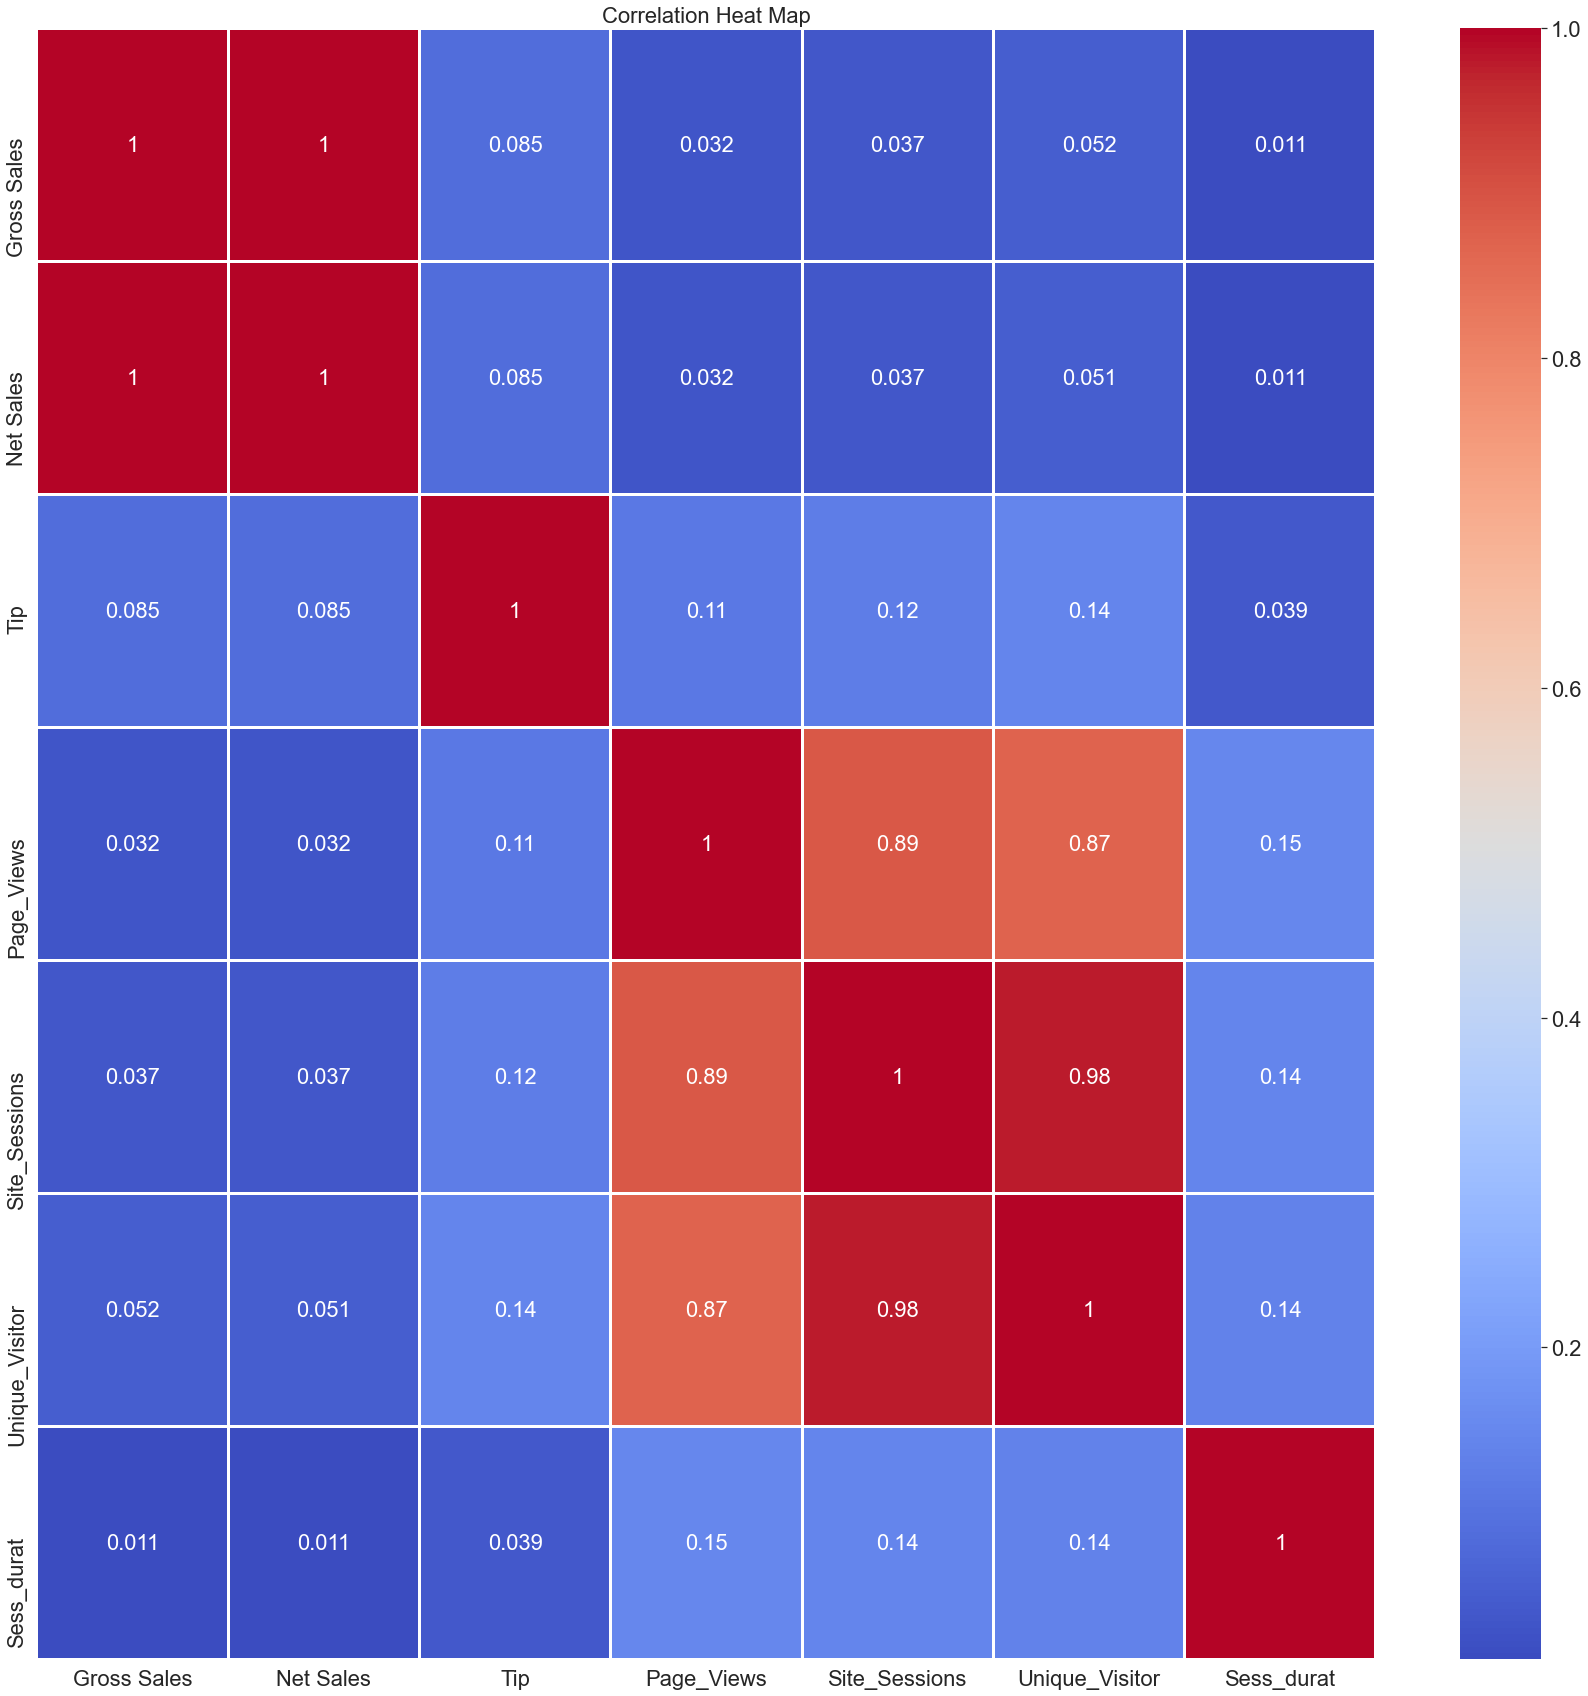

In [187]:
import seaborn as sns

sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
sns.heatmap(df_1.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2, annot_kws={"size": 22})
plt.title('Correlation Heat Map', fontsize = 22)
plt.show()

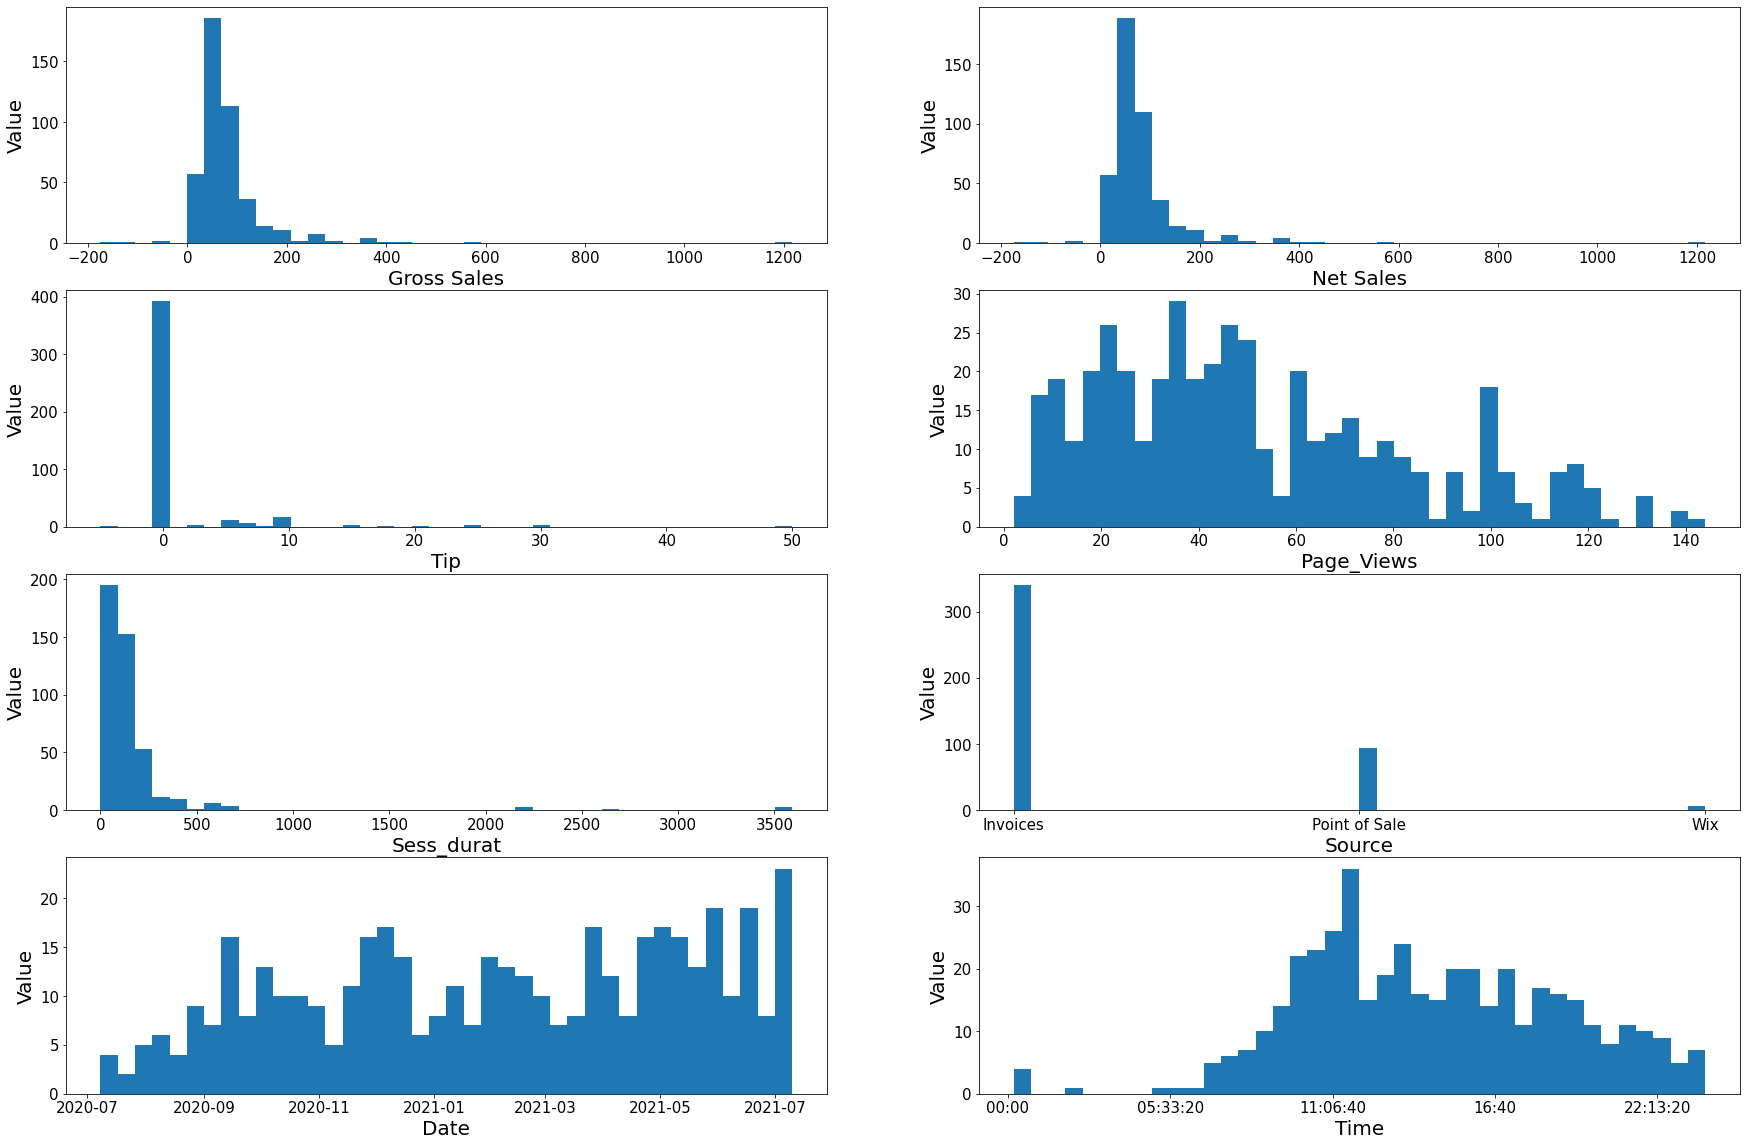

In [225]:
plt.rcParams['figure.figsize'] = (30, 20)

fig, axes = plt.subplots(nrows = 4, ncols = 2)

# Specify the features of interest
num_features = ['Gross Sales', 'Net Sales', 'Tip', 'Page_Views', 'Sess_durat', 'Source', 'Date', "Time"]
xaxes = num_features
yaxes = ['Value', 'Value', 'Value', 'Value', 'Value', 'Value', 'Value', 'Value']


# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(df_1[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

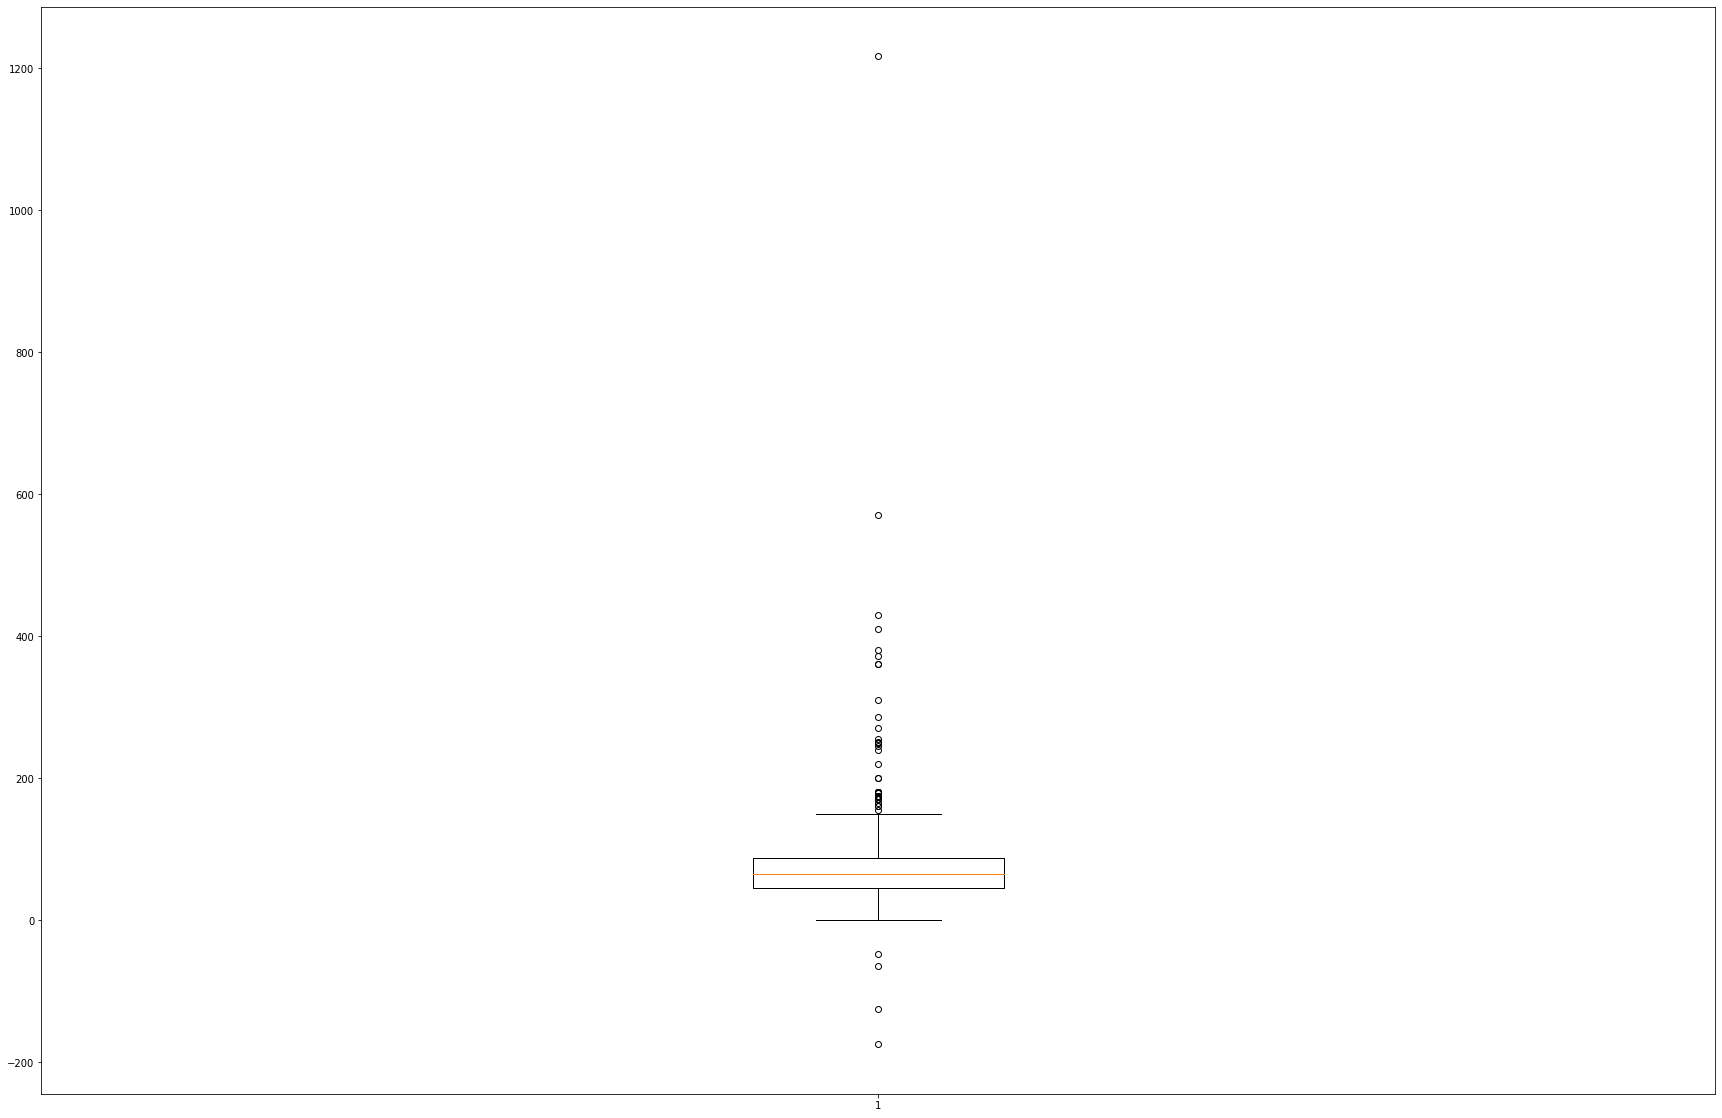

In [226]:
#Boxplot of variables

plt.boxplot(df_1["Net Sales"])
plt.show

In [227]:
df_1.describe()

,Gross Sales,Net Sales,Tip,Page_Views,Site_Sessions,Unique_Visitor,Sess_durat
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,79.217955,79.075909,1.130682,51.379545,15.352273,13.947727,168.590909
std,85.957865,85.993580,4.372136,31.951687,6.688718,6.232730,368.847520
min,-175.000000,-175.000000,-5.000000,2.000000,2.000000,2.000000,0.000000
25%,45.000000,44.750000,0.000000,26.000000,10.000000,9.000000,53.750000
50%,65.000000,65.000000,0.000000,46.000000,15.000000,13.000000,98.000000
75%,87.750000,87.000000,0.000000,70.250000,21.000000,18.250000,164.250000
max,1216.800000,1216.800000,50.000000,144.000000,37.000000,36.000000,3592.000000


<function matplotlib.pyplot.show(*args, **kw)>

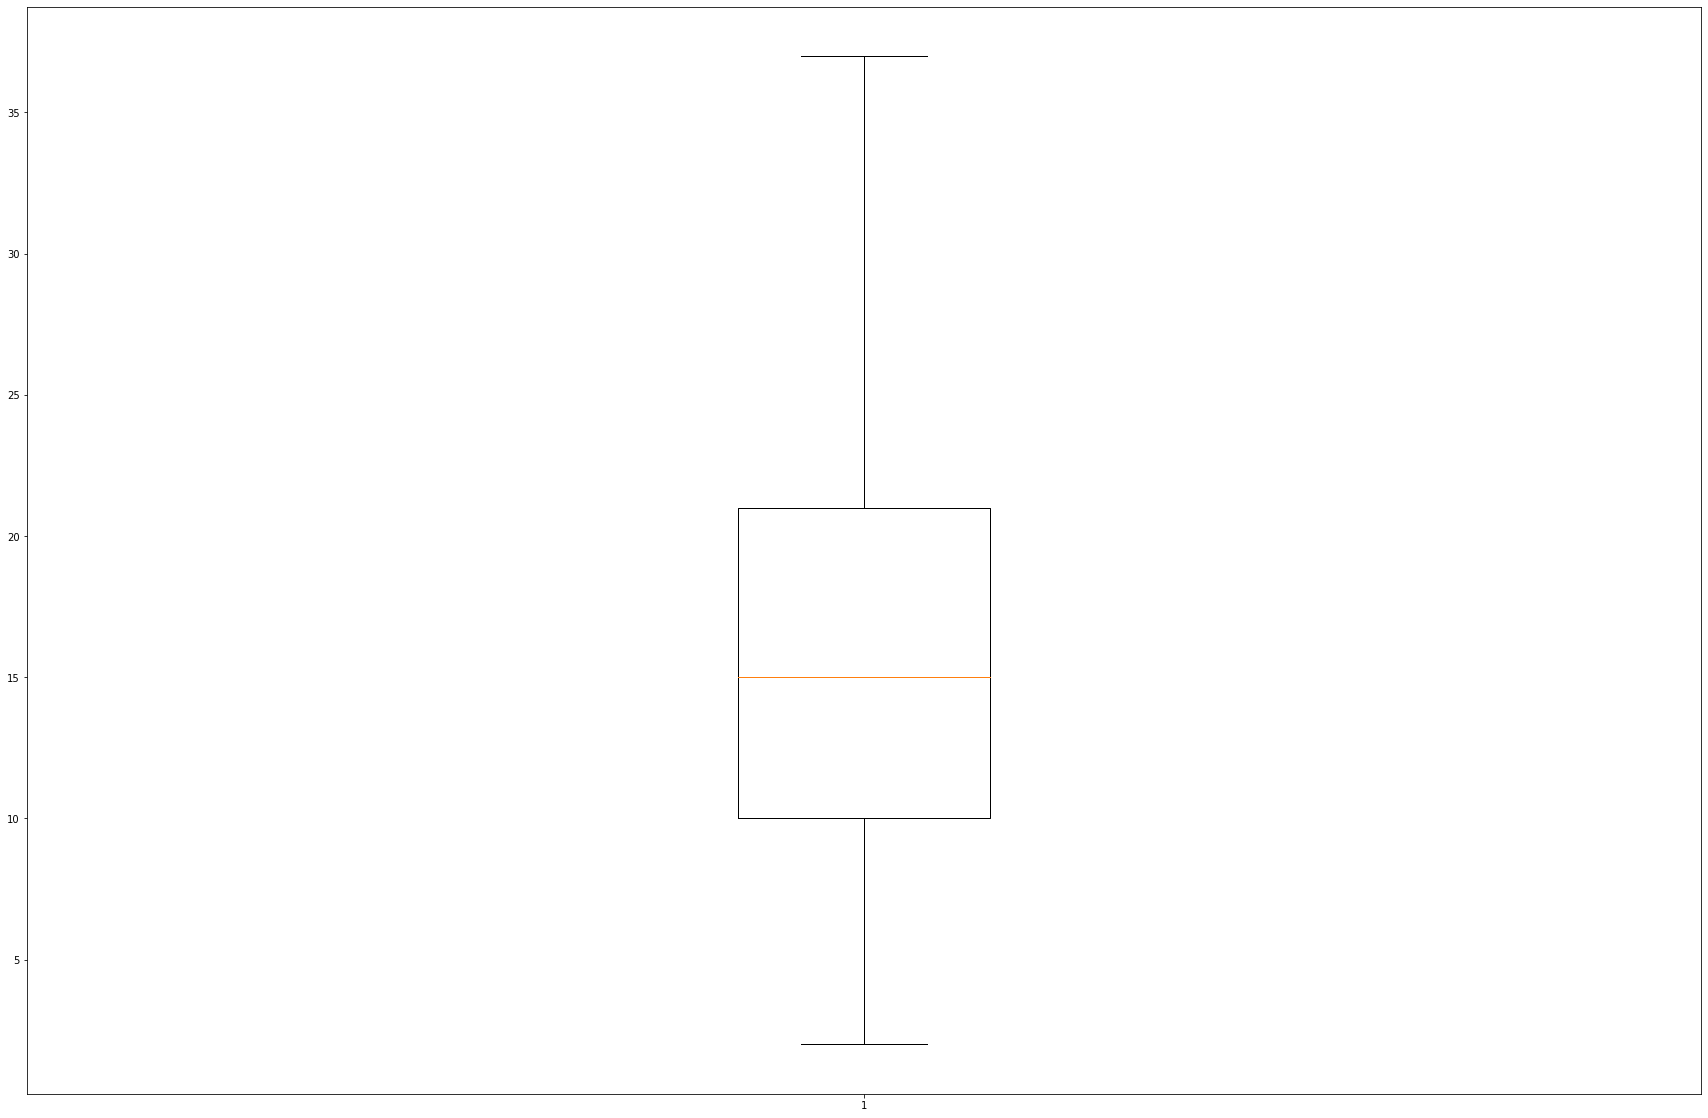

In [228]:
plt.boxplot(df_1["Site_Sessions"])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

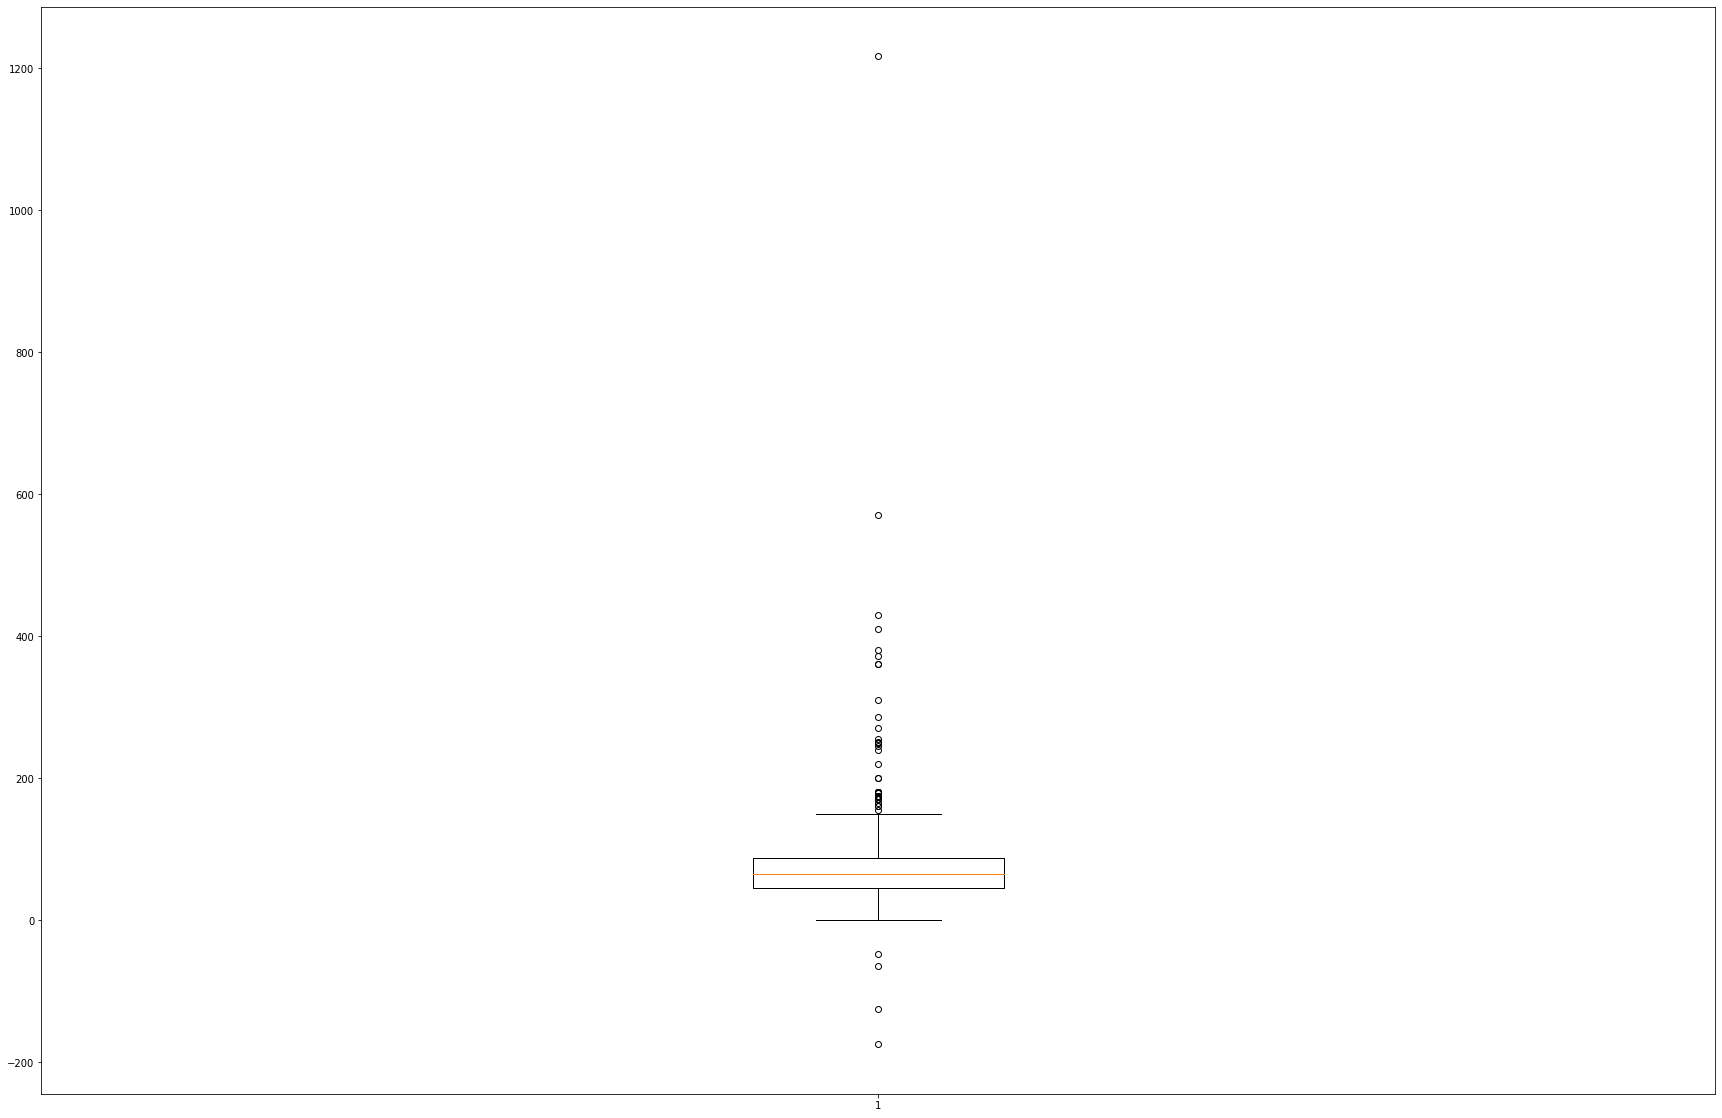

In [229]:
plt.boxplot(df_1["Net Sales"])
plt.show

Session duration of more than 2000 seconds will be counted as outliers and drop them

In [230]:
df_1.drop(df_1['Net Sales'].idxmax(), inplace = True)

In [237]:
df_1.drop(df_1['Sess_durat'].idxmax(), inplace = True)

<function matplotlib.pyplot.show(*args, **kw)>

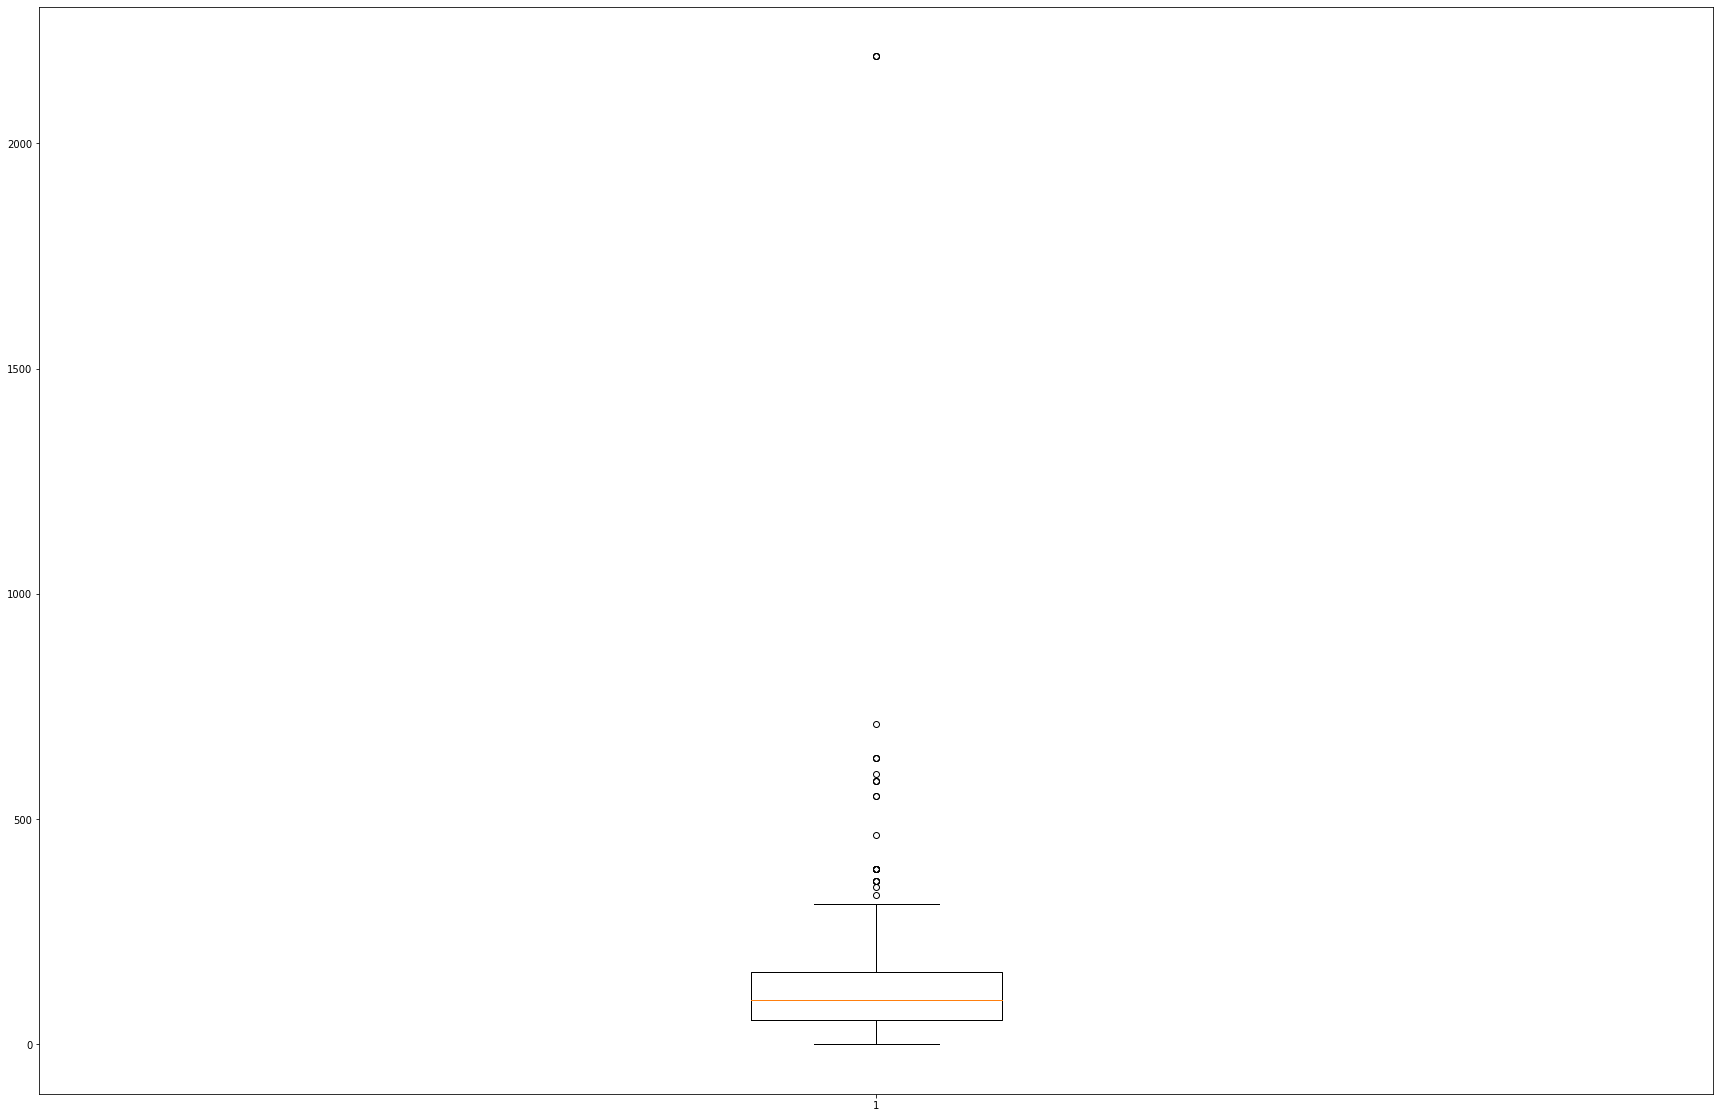

In [238]:
plt.boxplot(df_1["Sess_durat"])
plt.show

## Observation corresponding to Net Sales Value of $1216 was a unic sale made in December 2020 to a High School in town and it can be tagged as an outlier

In [239]:
from sklearn import linear_model

In [240]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [241]:
df_model = df_1

In [242]:
import datetime as dt

In [243]:
df_model['Date']=df_model['Date'].map(dt.datetime.toordinal)

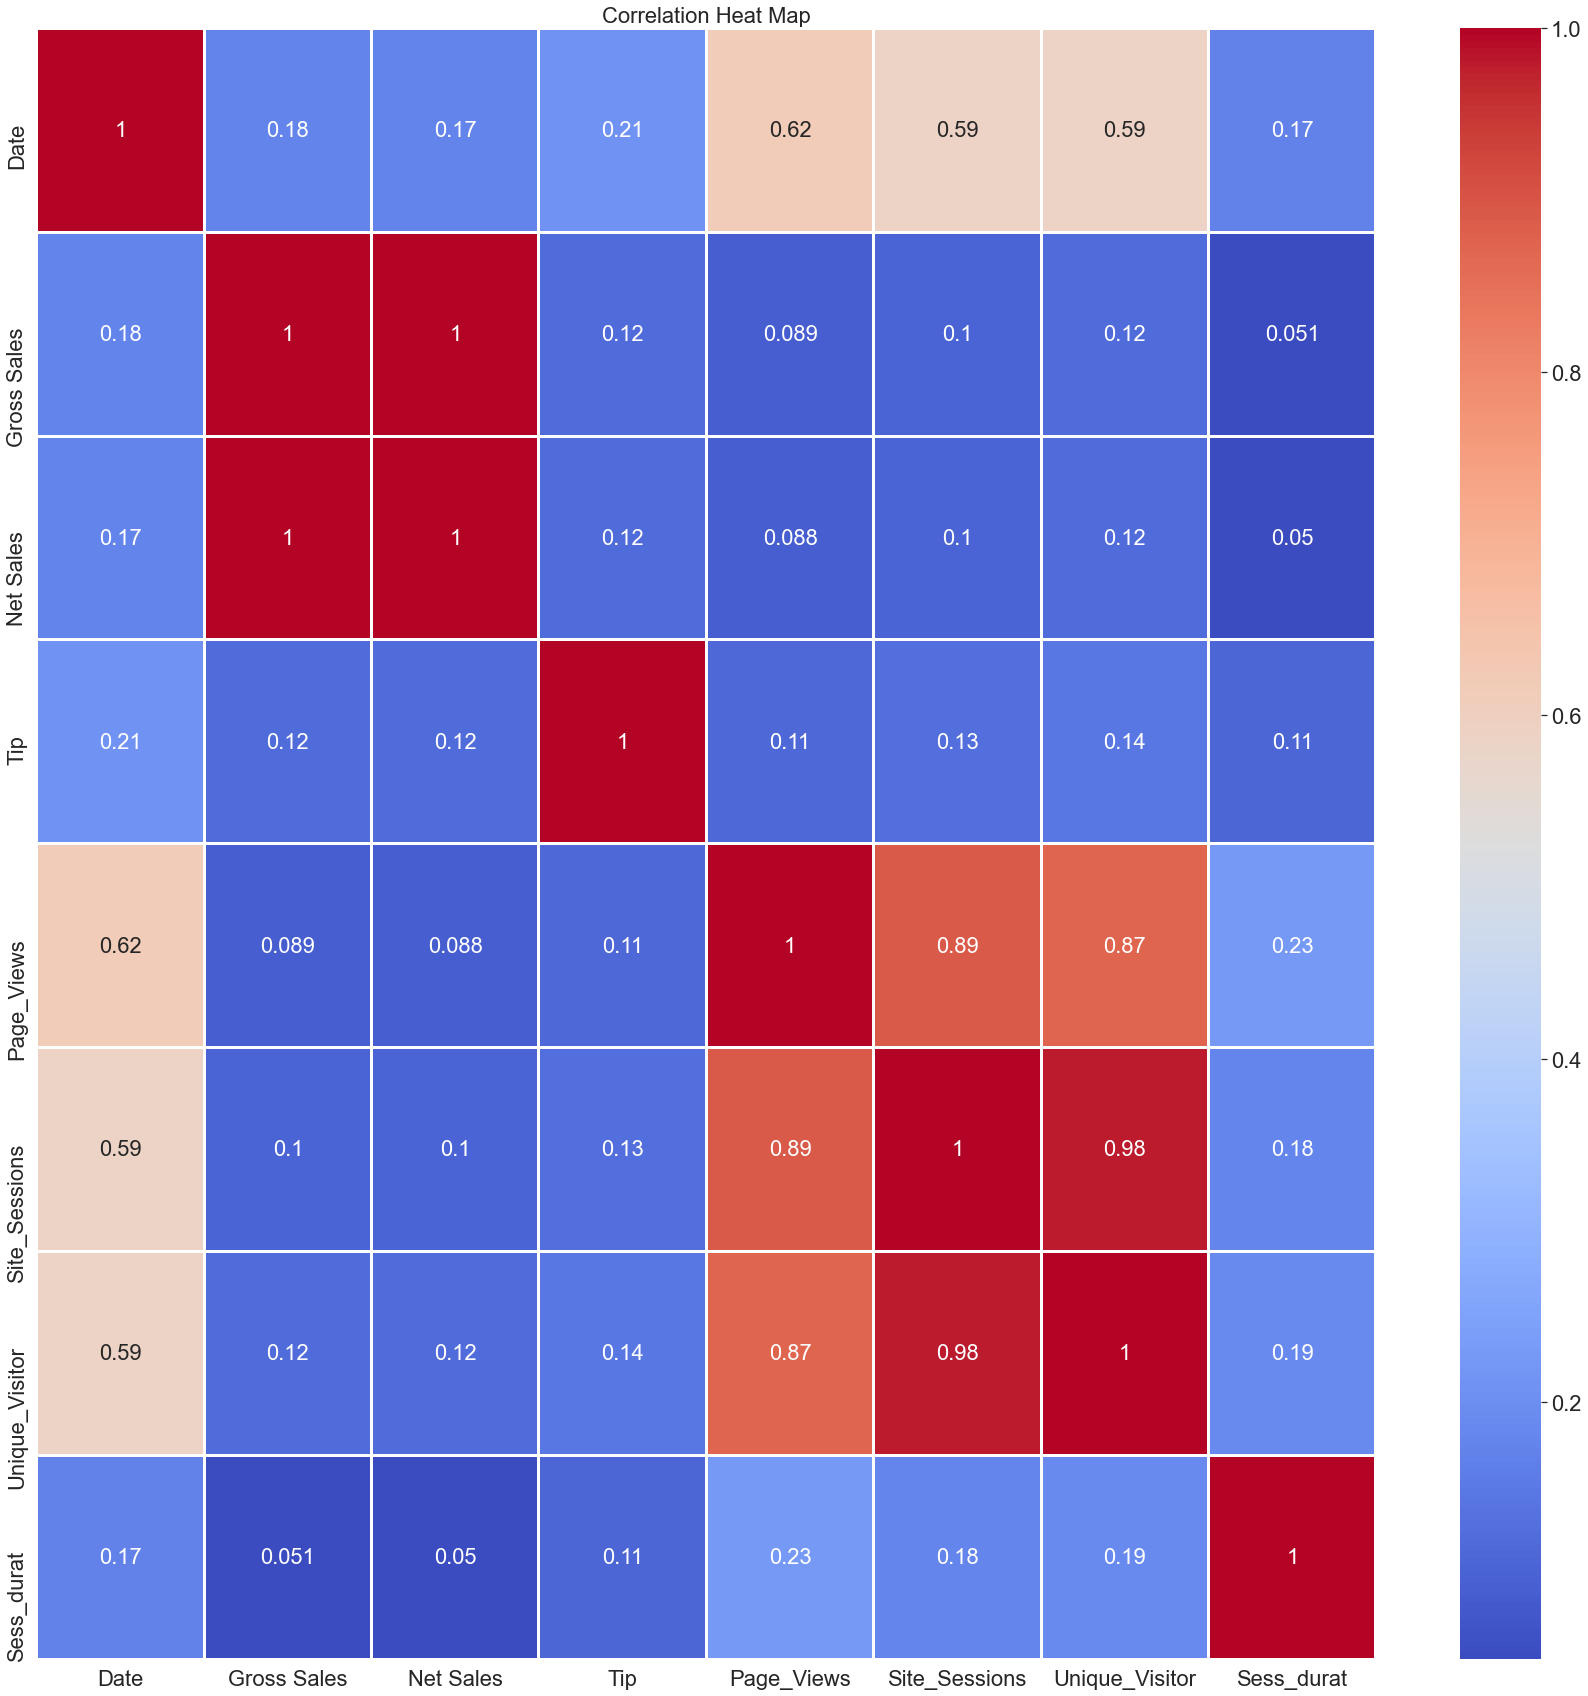

In [244]:
sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
sns.heatmap(df_model.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2, annot_kws={"size": 22})
plt.title('Correlation Heat Map', fontsize = 22)
plt.show()

In [245]:
df_model.drop(columns = "Gross Sales", inplace = True)

In [246]:
df_model.drop(columns = "Time", inplace=True)


In [247]:
df_model.drop(columns = "Source", inplace=True)

In [248]:
df_model.drop(columns = "Site_Bounce_Rate", inplace=True)

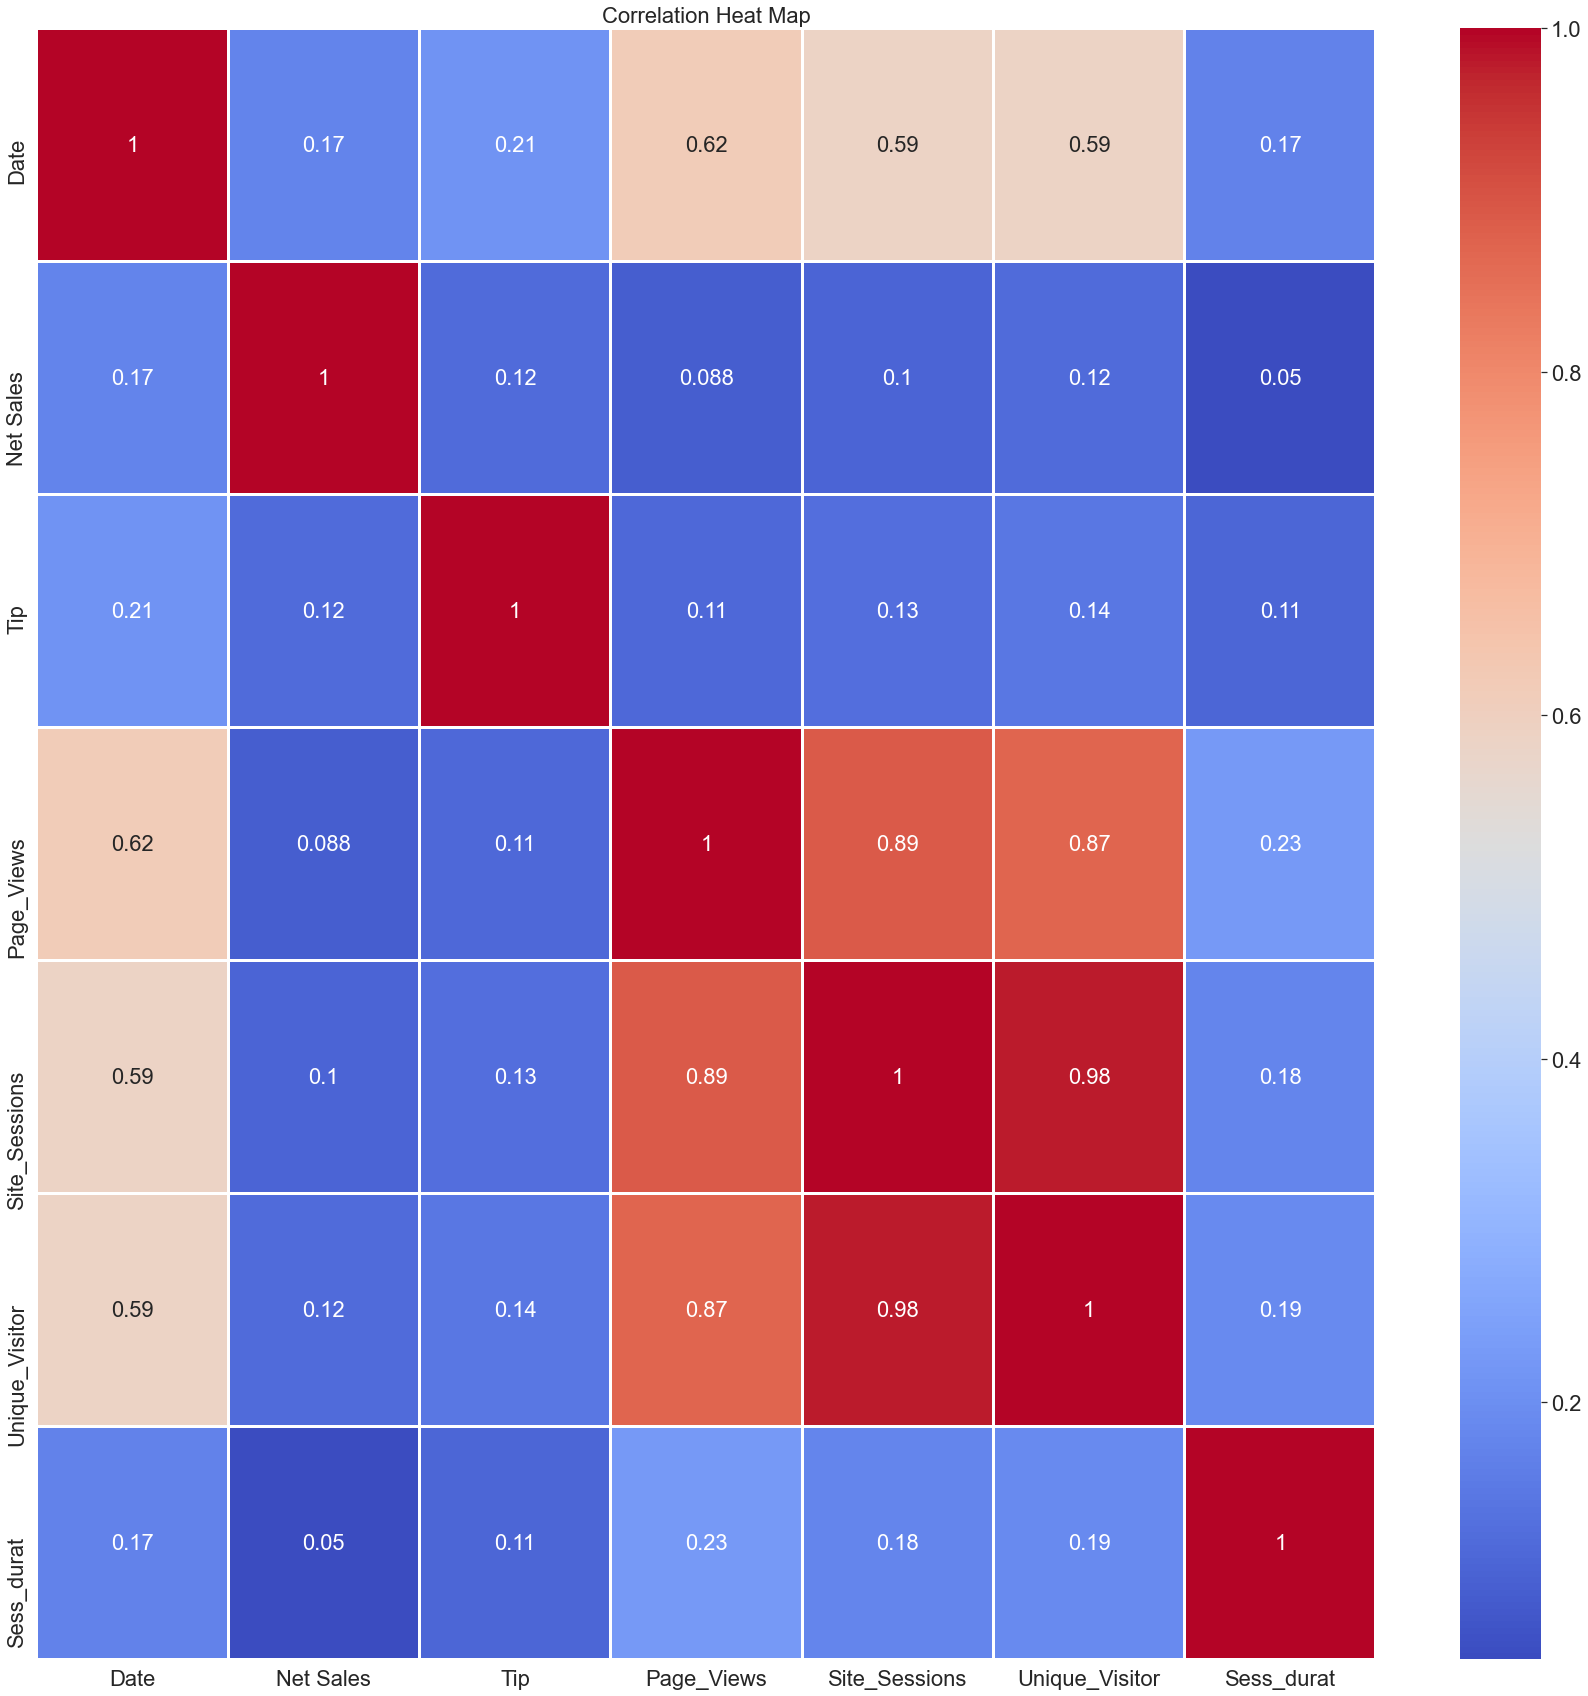

In [249]:
sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
sns.heatmap(df_model.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2, annot_kws={"size": 22})
plt.title('Correlation Heat Map', fontsize = 22)
plt.show()

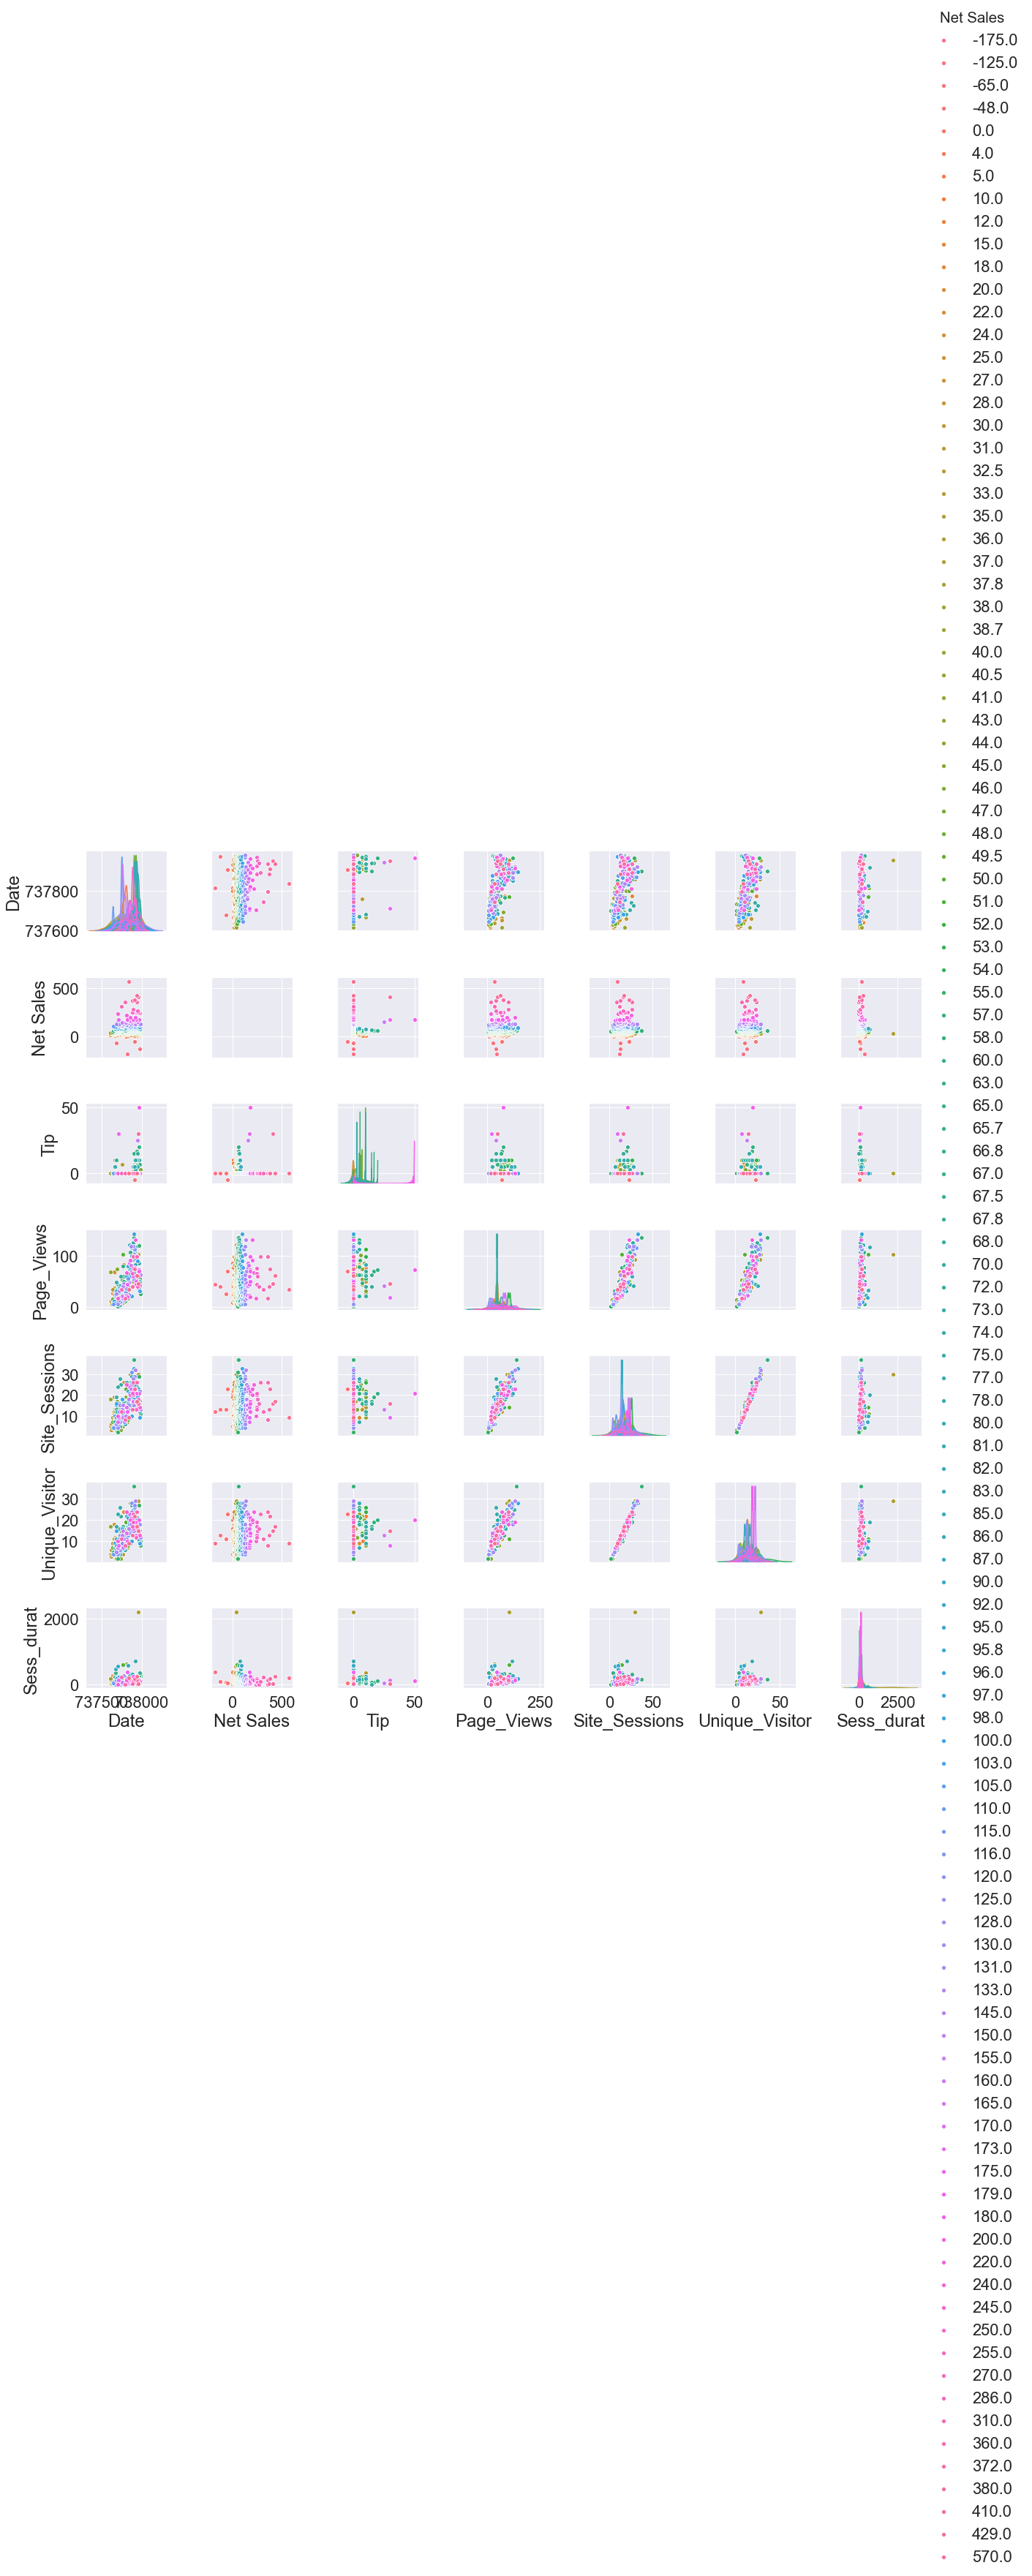

In [251]:



sns.pairplot(df_1, hue='Net Sales')  

plt.show()

In [250]:
target = df_model["Net Sales"]

In [251]:
X_train, X_test, y_train, y_test = train_test_split(df_model.loc[:, df_model.columns != 'Net Sales'], target, test_size=0.5, random_state=22)

In [252]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [253]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('R2: \n', regr.score(X_train,y_train))

Intercept: 
 -132878.79609816466
Coefficients: 
 [ 0.18021187 -1.62813419 -0.02725015 -3.65368809  3.29653761  0.02312235]
R2: 
 0.06957097291236392


In [254]:
y_pred = regr.predict(X_test)

Text(0.5, 1.0, 'Actua Values Vs. Predicted Values')

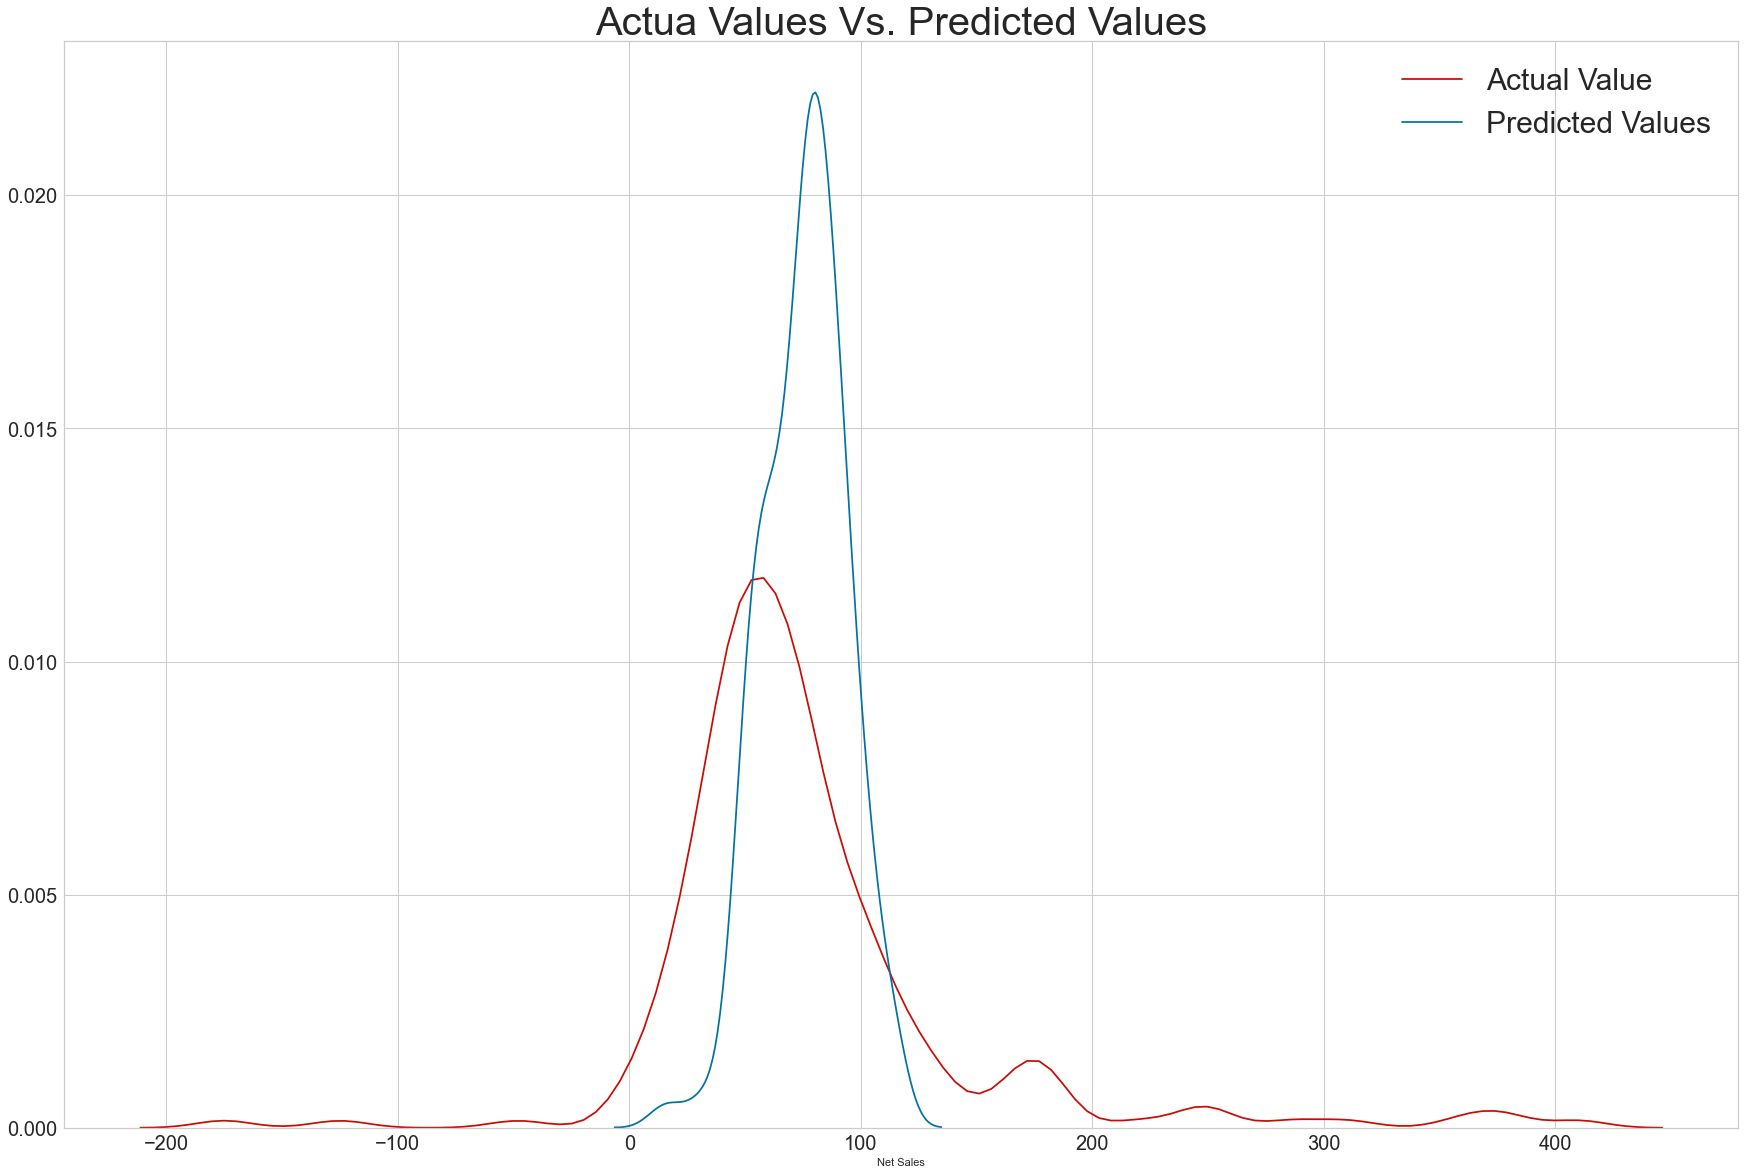

In [268]:
plt.rcParams['figure.figsize'] = (30, 20)
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")

sns.distplot(y_pred, hist=False, color="b", label="Predicted Values" , ax=ax1)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 30)
plt.title("Actua Values Vs. Predicted Values", fontsize = 40)

In [261]:
pip install -U yellowbrick

  Found existing installation: yellowbrick 1.1
    Uninstalling yellowbrick-1.1:
      Successfully uninstalled yellowbrick-1.1
Note: you may need to restart the kernel to use updated packages.


In [262]:
from yellowbrick.regressor import ResidualsPlot

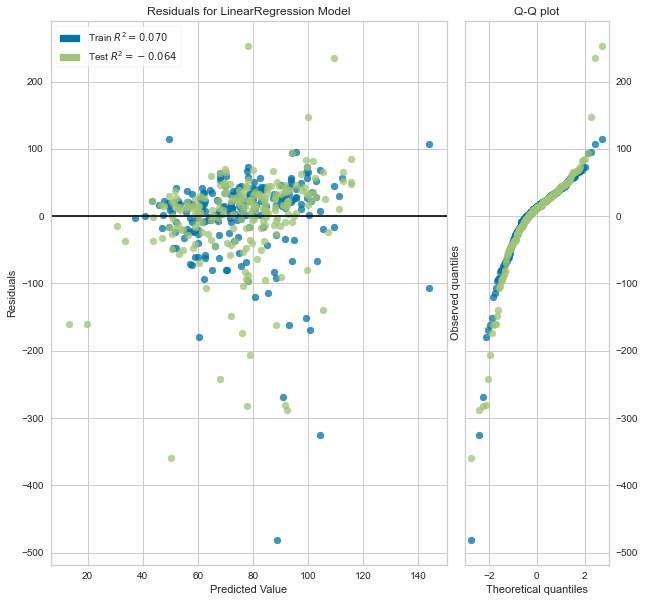

In [272]:
plt.rcParams['figure.figsize'] = (10, 10)

visualizer = ResidualsPlot(regr, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# ARIMA and Time Series

In [26]:
df_2 = pd.read_csv("df_final1.csv")

In [27]:
df_2.head()

,Unnamed: 0,Date,Time,Gross Sales,Net Sales,Tip,Source,Page_Views,Site_Sessions,Unique_Visitor,Site_Bounce_Rate,Sess_durat
0,0,2020-12-31,14:02:13,55.0,55.0,0.0,Invoices,11,6,6,67.00%,32
1,1,2020-12-28,08:56:42,45.0,45.0,0.0,Invoices,30,9,9,44.00%,235
2,2,2020-12-27,10:17:39,130.0,130.0,0.0,Point of Sale,15,7,7,57.00%,7
3,3,2020-12-26,17:06:22,60.0,60.0,0.0,Invoices,30,12,10,50.00%,89
4,4,2020-12-23,13:54:09,45.0,45.0,0.0,Invoices,19,10,10,70.00%,20


In [28]:
df_2.drop(columns = "Unnamed: 0", inplace = True)

In [29]:
df_2.drop(df_2['Net Sales'].idxmax(), inplace = True)

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

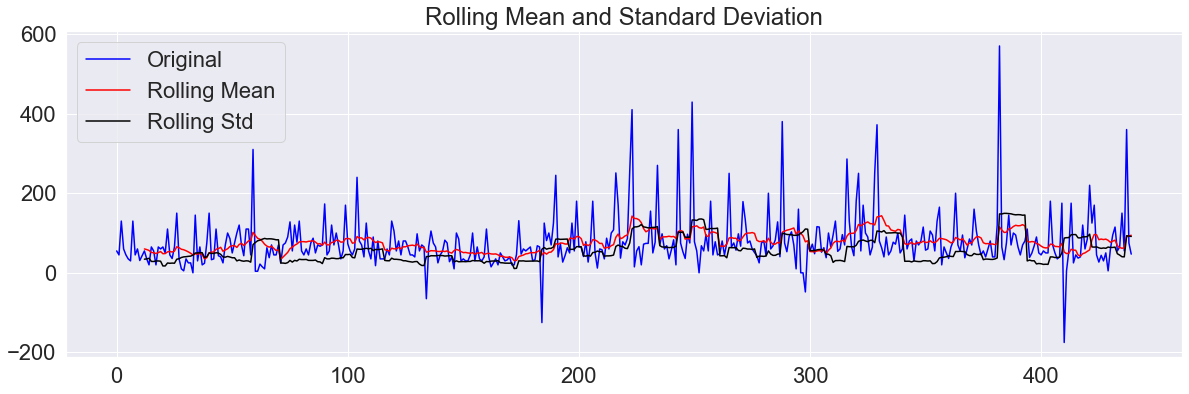

Results of dickey fuller test
Test Statistics                -19.289351
p-value                          0.000000
No. of lags used                 0.000000
Number of observations used    438.000000
critical value (1%)             -3.445368
critical value (5%)             -2.868161
critical value (10%)            -2.570297
dtype: float64


In [280]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
   
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_2["Net Sales"])

Because i got a p-value of 0.00 I can assume that my data is stationary

In [281]:
target = df_2["Net Sales"]

In [284]:
X_train, X_test, y_train, y_test = train_test_split(df_2.loc[:, df_2.columns != 'Net Sales'], target, test_size=0.6, random_state=22)

In [115]:
from statsmodels.tsa.arima_model import ARIMA


In [16]:
from pmdarima.arima import auto_arima

In [33]:
df_2.set_index('Date', inplace = True)

In [38]:
df_model_2 = df_2["Net Sales"]

In [40]:
df_model_2

Date
2020-12-31     55.0
2020-12-28     45.0
2020-12-27    130.0
2020-12-26     60.0
2020-12-23     45.0
              ...  
2021-01-07    150.0
2021-01-06     55.0
2021-01-05    360.0
2021-01-02     75.0
2021-01-02     47.0
Name: Net Sales, Length: 439, dtype: float64

In [64]:
train_data, test_data = df_model_2[3:int(len(df_model_2)*0.9)], df_model_2[int(len(df_model_2)*0.9):]

In [65]:
train_data

Date
2020-12-26     60.0
2020-12-23     45.0
2020-12-22     35.0
2020-12-21     30.0
2020-12-19    130.0
              ...  
2021-02-09     45.0
2021-02-09     70.0
2021-02-08     80.0
2021-02-07    110.0
2021-02-07     38.7
Name: Net Sales, Length: 392, dtype: float64

In [66]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4733.014, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4548.574, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4627.970, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4511.431, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4490.528, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4397.715, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4397.153, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4396.185, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4397.020, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4586.929, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4398.727, Time=0.06 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.783 seconds
                               SARIMAX Results                                
Dep. Variable:

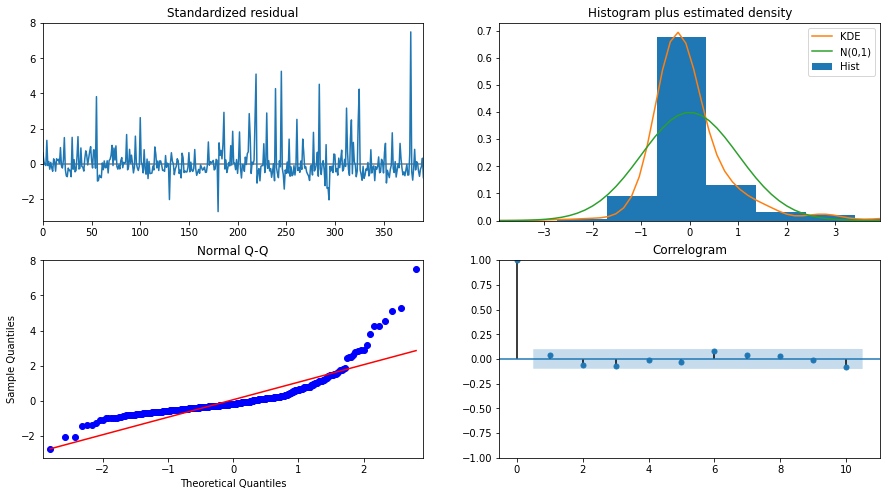

In [67]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [78]:
df_model_log = np.log(df_model_2)

In [79]:
df_model_log.isnull().sum()

4

In [80]:
df_model_log = df_model_log.dropna()

In [81]:
df_model_log.isnull().sum()

0

In [105]:
df_model_log.replace([np.inf, -np.inf], np.nan, inplace=True)

In [109]:
df_model_log.isnull().sum()

4

In [110]:
df_model_log.dropna(inplace=True)

In [111]:
train_data, test_data = df_model_log[3:int(len(df_model_log)*0.9)], df_model_log[int(len(df_model_log)*0.9):]

In [112]:
train_data.isnull().sum()

0

In [113]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2193.227, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=970.181, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1781.959, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=772.701, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=770.053, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=771.969, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=770.119, Time=0.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=769.886, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1567.115, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=771.761, Time=0.33 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1410.763, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=768.564, Time=0.63 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=776.488, 

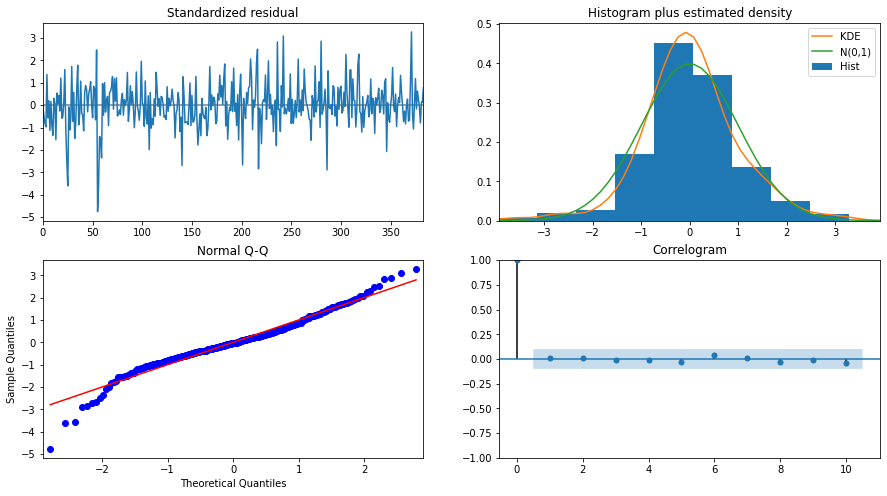

In [114]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [116]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Net Sales   No. Observations:                  383
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -374.785
Method:                       css-mle   S.D. of innovations              0.639
Date:                Wed, 21 Jul 2021   AIC                            763.569
Time:                        21:19:42   BIC                            791.206
Sample:                             1   HQIC                           774.532
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0016      0.000      4.454      0.000       0.001       0.002
ar.L1.D.Net Sales    -0.7440      0.095     -7.816      0.000      -0.931      -0.557
ar.L2.D.Net Sales     0.

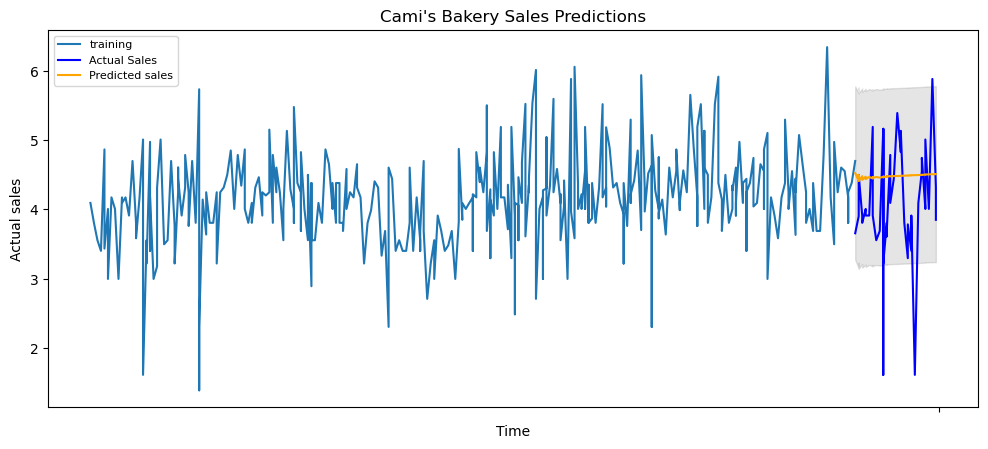

In [127]:
# Forecast
fc, se, conf = fitted.forecast(44, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Sales')
plt.plot(fc_series, color = 'orange',label='Predicted sales')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('''Cami's Bakery Sales Predictions''')
plt.xlabel('Time')
plt.xticks([' '], fontsize = 5, rotation = 90)
plt.ylabel('Actual sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [128]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.7951642582036615
MAE: 0.6933161122427687
RMSE: 0.8917198316756567
MAPE: 0.22042854285562863


## KNN Regression

In [273]:
df_knn = pd.read_csv("df_final1.csv")

In [274]:
df_knn.drop(columns = "Unnamed: 0", inplace = True)
df_knn.drop(df_knn['Net Sales'].idxmax(), inplace = True)

In [275]:
df_knn.isnull().sum()

Date                0
Time                0
Gross Sales         0
Net Sales           0
Tip                 0
Source              0
Page_Views          0
Site_Sessions       0
Unique_Visitor      0
Site_Bounce_Rate    0
Sess_durat          0
dtype: int64

In [276]:
df_knn = pd.get_dummies(df_knn)

In [277]:
target = df_knn["Net Sales"]

In [278]:
X_train, X_test, y_train, y_test = train_test_split(df_knn.loc[:, df_knn.columns != 'Net Sales'], target, test_size=0.5)

In [279]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(X_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(X_test)
x_test = pd.DataFrame(x_test_scaled)

In [280]:
from sklearn import neighbors
from math import sqrt


In [281]:
rmse_val = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 24.70740043718959
RMSE value for k=  2 is: 27.05200316057944
RMSE value for k=  3 is: 22.981303336197083
RMSE value for k=  4 is: 22.623462592165037
RMSE value for k=  5 is: 23.73603455431501
RMSE value for k=  6 is: 25.08161599376296
RMSE value for k=  7 is: 25.496410748161416
RMSE value for k=  8 is: 26.64022994575122
RMSE value for k=  9 is: 27.419738961854677
RMSE value for k=  10 is: 28.28127799446128


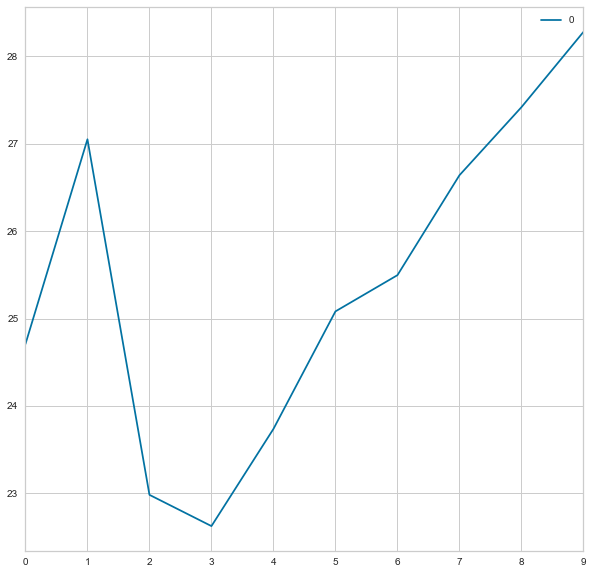

In [282]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [284]:
model = neighbors.KNeighborsRegressor(n_neighbors = 4)
model.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=4)

In [285]:
y_pred = model.predict(X_test)

In [286]:
import seaborn as sns

Text(0.5, 1.0, 'Actua Values Vs. Predicted Values')

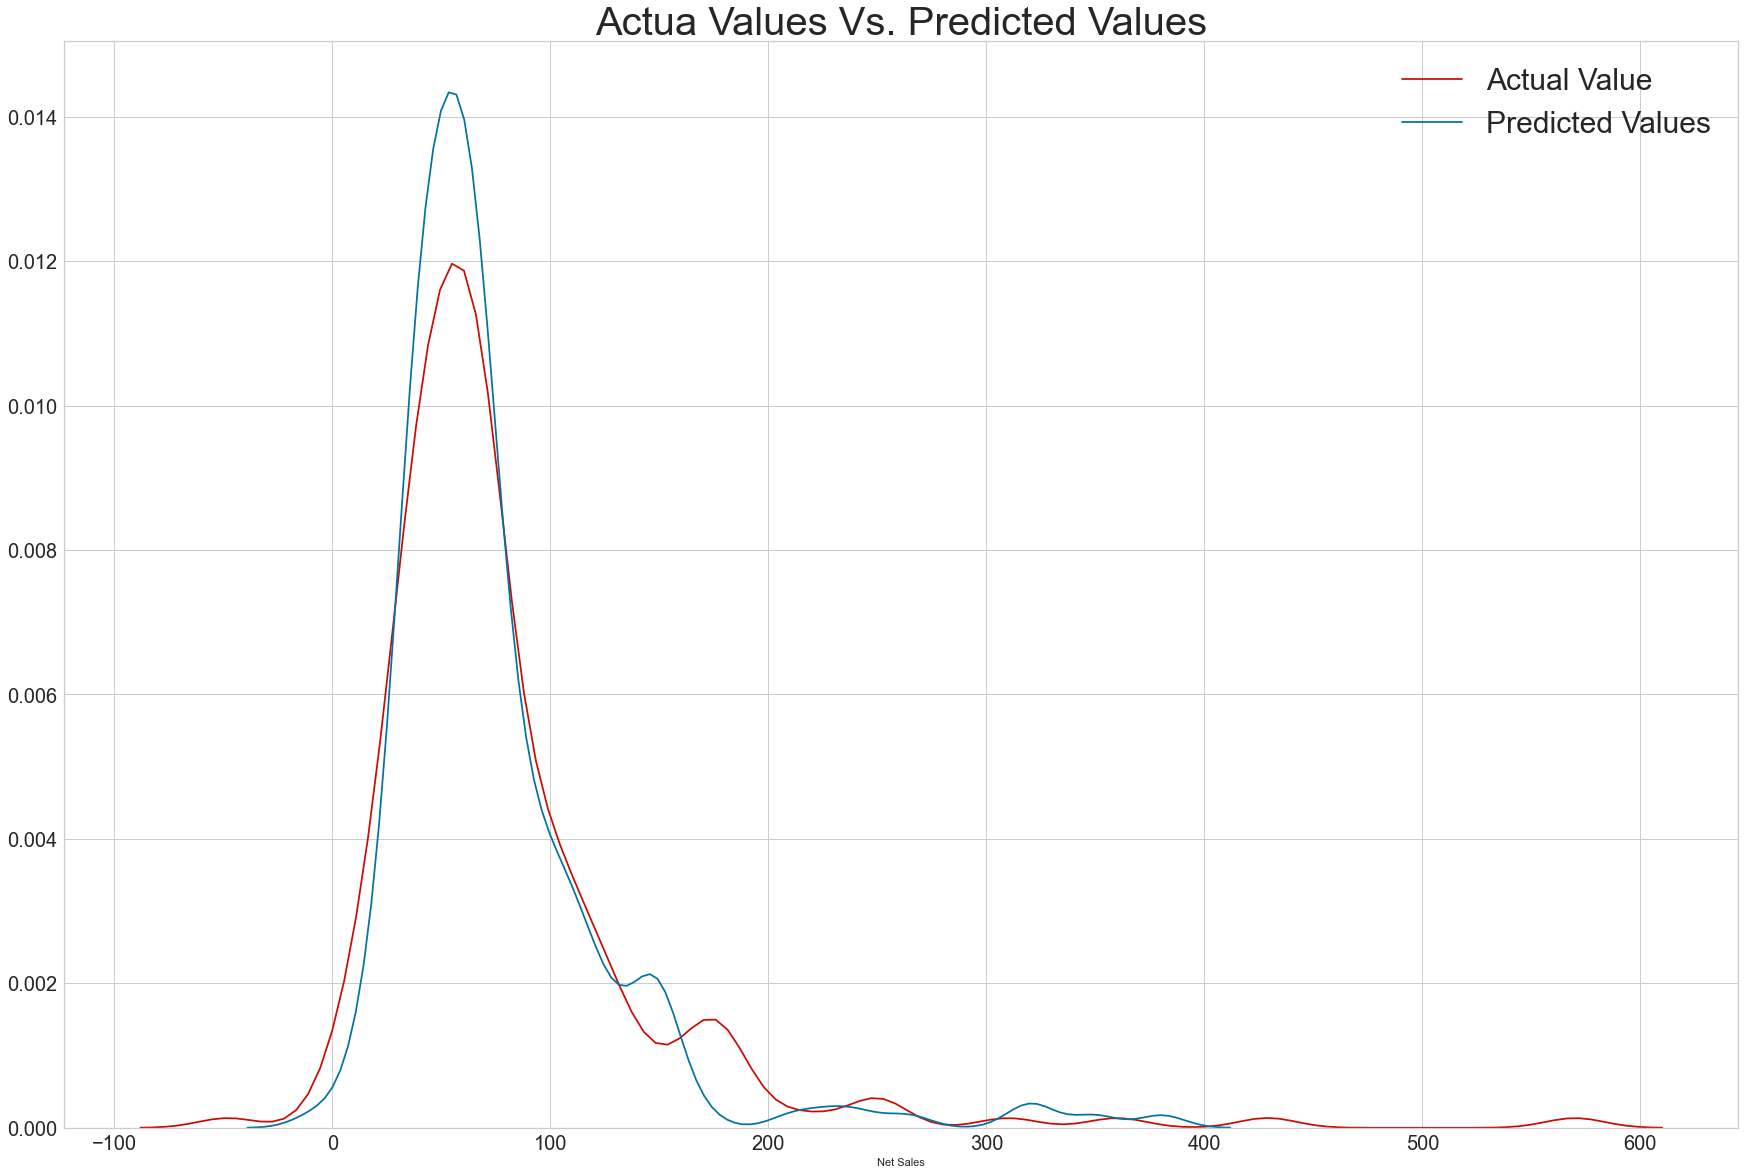

In [288]:
plt.rcParams['figure.figsize'] = (30, 20)
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")

sns.distplot(y_pred, hist=False, color="b", label="Predicted Values" , ax=ax1)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 30)
plt.title("Actua Values Vs. Predicted Values", fontsize = 40)

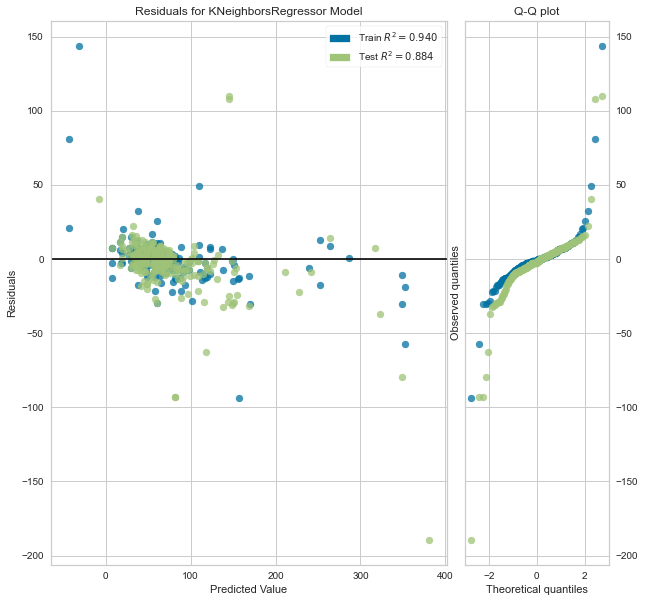

In [289]:
plt.rcParams['figure.figsize'] = (10, 10)

visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()